# Binary Environment

In [203]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Libraries

In [258]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
from utils.riskenv import (RiskManagementEnv, 
                           RiskManagementEnvMonthlyEpisodes, 
                           RiskManagementEnvDynaState)
from utils.common import (create_logger, predict_from_env,predict_from_frame_v2,
                          predict_from_frame, running_mean_last_n_samples, 
                          plot_actions_running_mean, plot_reward_history, 
                          plot_default_rate_history, get_csv_files, exponential_decay_schedule)        

from utils.networks import ConvNetwork, FCNetwork, LSTMNetwork, GRUNetwork, GRUNetworkBidirectional
from utils.constants import date_code_mapping
from sklearn.kernel_approximation import RBFSampler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3 import A2C, PPO, DQN
from sb3_contrib import TRPO, RecurrentPPO, QRDQN
from sklearn.preprocessing import MinMaxScaler, Normalizer
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from sklearn.metrics import (f1_score, recall_score, mean_absolute_error, 
                             accuracy_score, mean_squared_error, r2_score)
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style='whitegrid', context='paper', font_scale=1., palette='muted')


# Dataset

In [175]:
# fixed random seed
SEED=123
rng = np.random.default_rng(SEED)

In [176]:
fpath = "../data/dataset_1/processed/train_subset.csv"
train_subset = pd.read_csv(fpath)

In [177]:
original_features = ['mispay_days',
            'mispay_d_90d_12m',
            'total_balance',
            'income',
            'age',
            'mortgage',
            'mortgage_qty',
            'maturity_months',
            'monthly_payment',
            'subsidy',
            'interest_rate']

default_col = 'default_120_12m'
dates_from_codes = {v: k for k, v in date_code_mapping.items()}

In [178]:
# this is the convention used for input to the environment date is 1st index and client_id is 2nd index.
train_subset = train_subset.sort_values(by=['date_code', 'client_id']).set_index(["date_code", "client_id"])

In [179]:
# RBF feature transformation
FEATURE_EXPANSION = False
if FEATURE_EXPANSION:
    n_components = 200
    rbf_feature = RBFSampler(gamma=1, n_components=n_components,random_state=SEED)
    features = [f"x_{x}" for x in range(n_components)]
    train_transformed = pd.DataFrame(rbf_feature.fit_transform(train_subset[original_features]), columns=features)
    train_subset = train_subset[["default_120_12m"]].reset_index().merge(train_transformed, left_index=True, right_index=True)
    train_subset = train_subset.sort_values(by=['date_code', 'client_id']).set_index(["date_code", "client_id"])

In [180]:
SCALE = True
if SCALE:
    features = original_features if not FEATURE_EXPANSION else features
    scaler = MinMaxScaler((-1, 1))
    train_subset[features] = scaler.fit_transform(train_subset[features])
    train_subset[features] = train_subset[features].clip(-1, 1)

# Check Environment

In [181]:
LEARNING_STEPS = len(train_subset)
# Define environment configuration
CustomEnv = RiskManagementEnvMonthlyEpisodes

kwargs = {
    'features_col': features, # feature colums
    'default_col': default_col, # default column
    'obs_dim': len(features),
    'action_dim' : 3,  # 0,1
    'client_dim': len(train_subset.loc[0].index.unique()), # number of clients
    'model_name': "test"
}
check_env( CustomEnv(train_subset, debug=True, scaled_features=SCALE, seed=SEED, rng=rng, accepts_discrete_action=True, **kwargs), warn=True)

# Dueling DQN

In [182]:
from utils.duelingdqn import DuelingDQNPolicy

In [183]:
kwargs = {
    'features_col': features, # feature colums
    'default_col': 'default_120_12m', # default column
    'obs_dim': len(features),
    'action_dim' : 2,  # 0,1
    'client_dim': len(train_subset.loc[0].index.unique()), # number of clients
    'model_name': "test"
}

num_envs = 1
env_fns = [lambda : CustomEnv(train_subset, debug=True, scaled_features=SCALE, seed=SEED, rng = rng, accepts_discrete_action=True, **kwargs) for i in range(num_envs)]
training_env = SubprocVecEnv(env_fns)
log_path = "logs/binary/dueldqn"
logger = create_logger(log_path)

In [184]:
feature_extractor = GRUNetwork
# Now use the custom network in policy_kwargs
policy_kwargs = dict(
    features_extractor_class=feature_extractor,
    features_extractor_kwargs=dict(first_layer=400,
                                   first_layer_dropout=0.1,
                                   output_layer=400,
                                   output_layer_dropout=0.1)
    )
model_dueldqn = DQN(DuelingDQNPolicy, 
                training_env, 
                verbose=1, 
                device="cpu",
                learning_rate=1e-3, 
                gamma=0.9, 
                policy_kwargs=policy_kwargs,
                buffer_size=1_000_000, 
                learning_starts=100, 
                batch_size=64, 
                tau=1.0, 
                train_freq=2
                )
model_dueldqn.set_logger(logger)
model_dueldqn.learn(LEARNING_STEPS*3,log_interval=1)
model_dueldqn.save("output/binary/dueldqn")

Using cpu device
default: 0.333 - penalty: -1.70 reward: -1.58 - client:  207.0 month:   1 - done: True
default: 0.342 - penalty: -1.83 reward:  3.61 - client:  394.0 month:   2 - done: True
default: 0.342 - penalty: -1.84 reward:  3.61 - client:  470.0 month:   3 - done: True
default: 0.357 - penalty: -1.86 reward:  3.55 - client:  588.0 month:   4 - done: True
default: 0.318 - penalty: -1.68 reward:  2.74 - client:   26.0 month:   5 - done: True
default: 0.337 - penalty: -1.81 reward:  2.64 - client:  375.0 month:   6 - done: True
default: 0.332 - penalty: -1.85 reward:  2.65 - client:  191.0 month:   7 - done: True
default: 0.318 - penalty: -1.67 reward:  2.74 - client:  366.0 month:   8 - done: True
default: 0.318 - penalty: -1.67 reward:  2.74 - client:  248.0 month:   9 - done: True
default: 0.302 - penalty: -1.63 reward:  2.83 - client:  139.0 month:  10 - done: True
default: 0.317 - penalty: -1.73 reward:  2.74 - client:  528.0 month:  11 - done: True
default: 0.337 - penalty: 

In [185]:
# Define environment configuration
n_steps = len(train_subset)
rew_dueldqn, _ = predict_from_env(model_dueldqn, training_env, n_steps)
act_dueldqn, date_codes = predict_from_frame(model_dueldqn, train_subset[features])

action: [0] - reward : [2.54939101] - done: [False]
action: [1] - reward : [3.5383097] - done: [False]
action: [0] - reward : [2.5302361] - done: [False]
action: [1] - reward : [3.54468744] - done: [False]
action: [0] - reward : [2.5356083] - done: [False]
action: [1] - reward : [3.5383097] - done: [False]
default: 0.357 - penalty: -1.93 reward:  2.54 - client:   15.0 month:   4 - done: True
action: [0] - reward : [2.69773879] - done: [False]
action: [0] - reward : [2.72631315] - done: [False]
action: [0] - reward : [2.73180769] - done: [False]
action: [1] - reward : [3.73727375] - done: [False]
action: [0] - reward : [2.73415921] - done: [False]
action: [0] - reward : [2.73727375] - done: [False]
default: 0.318 - penalty: -1.74 reward:  2.73 - client:  513.0 month:   5 - done: True
action: [0] - reward : [2.64846993] - done: [False]
action: [0] - reward : [2.64441836] - done: [False]
action: [0] - reward : [2.62752885] - done: [False]
action: [0] - reward : [2.63588498] - done: [False

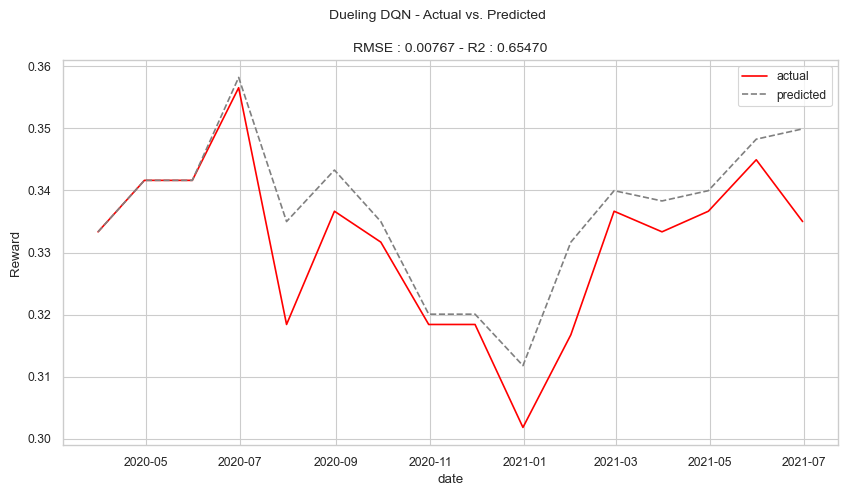

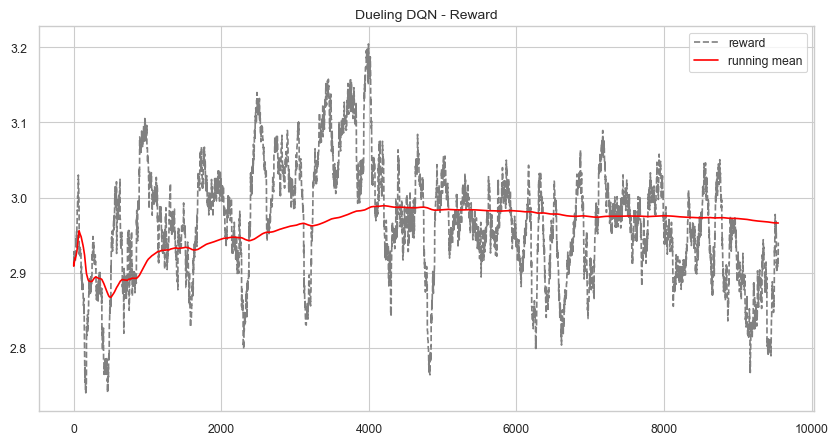

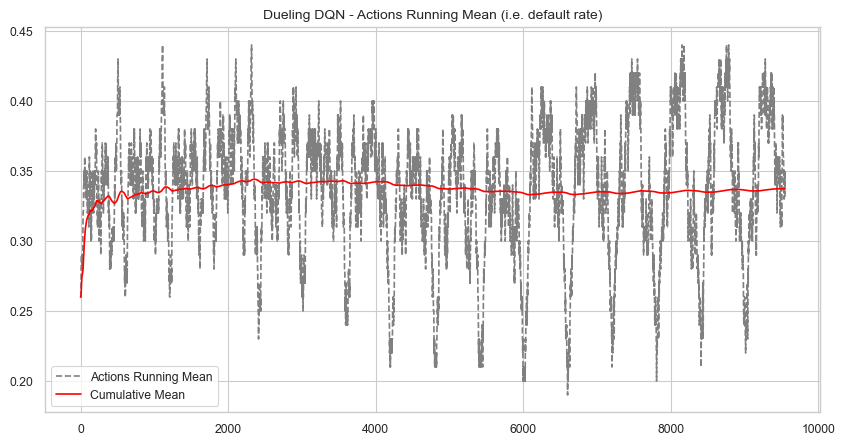

In [186]:
plot_default_rate_history(date_codes = date_codes,
                         actual = train_subset[default_col], 
                         actions = act_dueldqn,
                         dates_from_codes = dates_from_codes,
                         save_path="../imgs/2_modeling/dfr_history_dueldqn.png",
                         title = "Dueling DQN - Actual vs. Predicted")

plot_reward_history(reward = rew_dueldqn,
                    window_size=100,
                    save_path="../imgs/2_modeling/rew_history_dueldqn.png",
                    title = "Dueling DQN - Reward")

plot_actions_running_mean(actions=act_dueldqn,
                          window_size=100,
                          save_path="../imgs/2_modeling/act_run_mean_dueldqn.png",
                          title="Dueling DQN - Actions Running Mean (i.e. default rate)")


In [187]:
# [True Negative ,False Negative]
# [​False Positive, True Positive]
print("-"*30)
print(pd.DataFrame(confusion_matrix(train_subset[default_col].values, act_dueldqn), columns=["True 0", "True 1"], index=["Pred 0", "Pred 1"]))
print("-"*30)
print(classification_report(train_subset[default_col].values, act_dueldqn))

------------------------------
        True 0  True 1
Pred 0    6394      57
Pred 1       5    3192
------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      6451
         1.0       0.98      1.00      0.99      3197

    accuracy                           0.99      9648
   macro avg       0.99      0.99      0.99      9648
weighted avg       0.99      0.99      0.99      9648



# Double DQN

In [188]:
from utils.doubledqn import DoubleDQN

In [189]:
kwargs = {
    'features_col': features, # feature colums
    'default_col': 'default_120_12m', # default column
    'obs_dim': len(features),
    'action_dim' : 2,  # 0,1
    'client_dim': len(train_subset.loc[0].index.unique()), # number of clients
    'model_name': "test"
}

num_envs = 1
env_fns = [lambda : CustomEnv(train_subset, debug=True, scaled_features=SCALE, rng = rng, seed=SEED, accepts_discrete_action=True, **kwargs)for i in range(num_envs)]
training_env = SubprocVecEnv(env_fns)
log_path = "logs/binary/ddqn"
logger = create_logger(log_path)

In [190]:
feature_extractor = GRUNetwork
# Now use the custom network in policy_kwargs
policy_kwargs = dict(
    features_extractor_class=feature_extractor,
    features_extractor_kwargs=dict(first_layer=400,
                                   first_layer_dropout=0.1,
                                   output_layer=400,
                                   output_layer_dropout=0.1)
    )
model_ddqn = DoubleDQN("MlpPolicy", 
                training_env, 
                verbose=1, 
                device="cpu",
                learning_rate=1e-3, 
                gamma=0.9, 
                policy_kwargs=policy_kwargs,
                buffer_size=1_000_000, 
                learning_starts=100, 
                batch_size=64, 
                tau=1.0, 
                train_freq=2
                )
model_ddqn.set_logger(logger)
model_ddqn.learn(LEARNING_STEPS*3,log_interval=1)
model_ddqn.save("output/binary/ddqn")

Using cpu device
default: 0.333 - penalty: -1.56 reward:  2.69 - client:  207.0 month:   1 - done: True
default: 0.342 - penalty: -1.78 reward:  3.62 - client:  394.0 month:   2 - done: True
default: 0.342 - penalty: -1.77 reward:  3.62 - client:  470.0 month:   3 - done: True
default: 0.357 - penalty: -1.85 reward:  3.55 - client:  588.0 month:   4 - done: True
default: 0.318 - penalty: -1.70 reward:  2.73 - client:   26.0 month:   5 - done: True
default: 0.337 - penalty: -1.80 reward:  2.64 - client:  375.0 month:   6 - done: True
default: 0.332 - penalty: -1.82 reward:  2.66 - client:  191.0 month:   7 - done: True
default: 0.318 - penalty: -1.65 reward:  2.74 - client:  366.0 month:   8 - done: True
default: 0.318 - penalty: -1.65 reward:  2.74 - client:  248.0 month:   9 - done: True
default: 0.302 - penalty: -1.57 reward:  2.84 - client:  139.0 month:  10 - done: True
default: 0.317 - penalty: -1.76 reward:  2.73 - client:  528.0 month:  11 - done: True
default: 0.337 - penalty: 

In [191]:
n_steps = len(train_subset)
rew_ddqn, _ = predict_from_env(model_ddqn, training_env, n_steps)
act_ddqn, date_codes = predict_from_frame(model_ddqn, train_subset[features])

action: [0] - reward : [2.54553596] - done: [False]
action: [1] - reward : [3.5383097] - done: [False]
action: [0] - reward : [2.5340021] - done: [False]
action: [1] - reward : [3.54840649] - done: [False]
action: [0] - reward : [2.5356083] - done: [False]
action: [1] - reward : [3.5383097] - done: [False]
default: 0.357 - penalty: -1.93 reward:  2.54 - client:   15.0 month:   4 - done: True
action: [0] - reward : [2.69773879] - done: [False]
action: [0] - reward : [2.73024348] - done: [False]
action: [0] - reward : [2.73180769] - done: [False]
action: [1] - reward : [3.74271212] - done: [False]
action: [0] - reward : [2.73415921] - done: [False]
action: [0] - reward : [2.73727375] - done: [False]
default: 0.318 - penalty: -1.74 reward:  2.73 - client:  513.0 month:   5 - done: True
action: [0] - reward : [2.64846993] - done: [False]
action: [0] - reward : [2.64061435] - done: [False]
action: [0] - reward : [2.62752885] - done: [False]
action: [0] - reward : [2.64127775] - done: [False

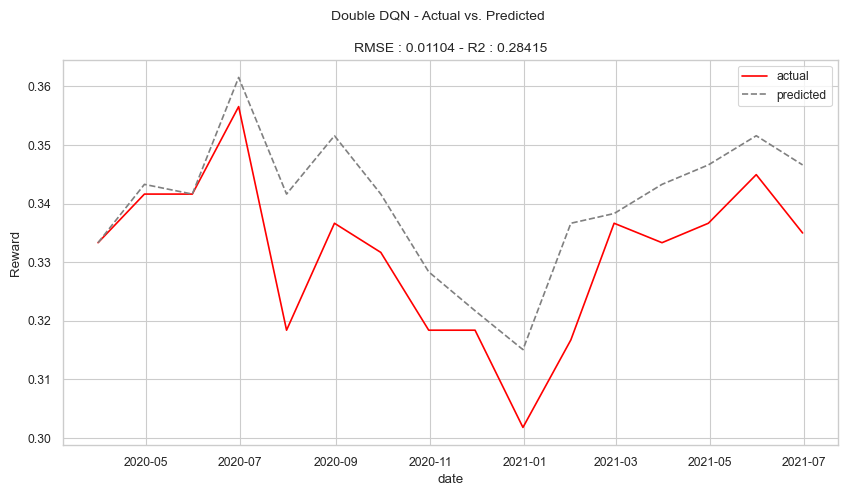

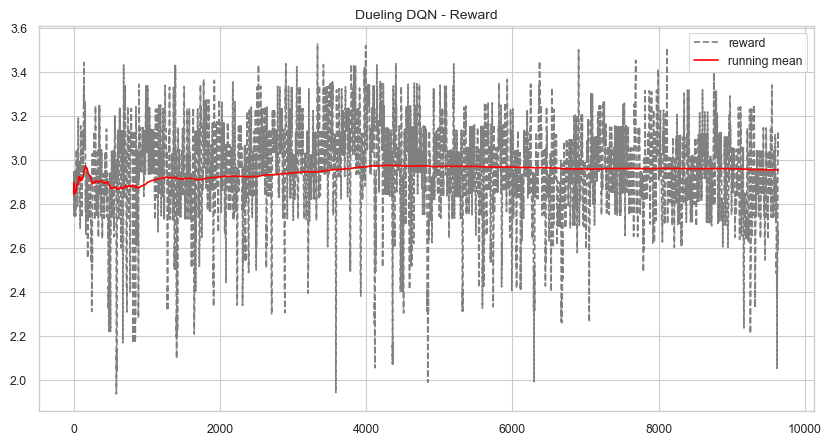

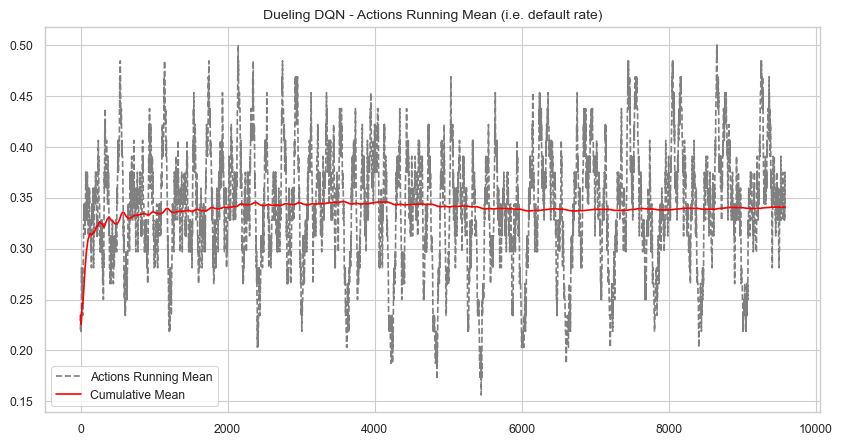

In [192]:
plot_default_rate_history(date_codes = date_codes,
                         actual = train_subset[default_col], 
                         actions = act_ddqn,
                         dates_from_codes = dates_from_codes,
                         save_path="../imgs/2_modeling/dfr_history_ddqn.png",
                         title = "Double DQN - Actual vs. Predicted",)

plot_reward_history(reward = rew_ddqn,
                    window_size=10,
                    save_path="../imgs/2_modeling/rew_history_ddqn.png",
                    title = "Dueling DQN - Reward")

plot_actions_running_mean(actions=act_ddqn,
                          window_size=64,
                          save_path="../imgs/2_modeling/act_run_mean_ddqn.png",
                          title="Dueling DQN - Actions Running Mean (i.e. default rate)")

In [193]:
# [True Negative ,False Negative]
# [​False Positive, True Positive]
print("-"*30)
print(pd.DataFrame(confusion_matrix(train_subset[default_col].values, act_ddqn), columns=["True 0", "True 1"], index=["Pred 0", "Pred 1"]))
print("-"*30)
print(classification_report(train_subset[default_col].values, act_ddqn))

------------------------------
        True 0  True 1
Pred 0    6364      87
Pred 1       2    3195
------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      6451
         1.0       0.97      1.00      0.99      3197

    accuracy                           0.99      9648
   macro avg       0.99      0.99      0.99      9648
weighted avg       0.99      0.99      0.99      9648



# DQN

In [194]:
kwargs = {
    'features_col': features, # feature colums
    'default_col': 'default_120_12m', # default column
    'obs_dim': len(features),
    'action_dim' : 2,  # 0,1
    'client_dim': len(train_subset.loc[0].index.unique()), # number of clients
    'model_name': "test"
}

num_envs = 1
env_fns = [lambda : CustomEnv(train_subset, debug=True, scaled_features=SCALE, seed=SEED, rng=rng, accepts_discrete_action=True, **kwargs)for i in range(num_envs)]
training_env = SubprocVecEnv(env_fns)
log_path = "logs/binary/dqn"
logger = create_logger(log_path)


In [195]:
feature_extractor = GRUNetwork
# Now use the custom network in policy_kwargs
policy_kwargs = dict(
    features_extractor_class=feature_extractor,
    features_extractor_kwargs=dict(first_layer=400,
                                   first_layer_dropout=0.3,
                                   output_layer=400,
                                   output_layer_dropout=0.1)
)

model_dqn = DQN("MlpPolicy", 
                training_env, 
                verbose=1, 
                device="cpu",
                seed=SEED,
                learning_rate=1e-3, 
                gamma=0.9, 
                policy_kwargs=policy_kwargs,
                buffer_size=1_000_000, 
                learning_starts=100, 
                batch_size=64, 
                tau=1.0, 
                train_freq=2
                )
model_dqn.set_logger(logger)
model_dqn.learn(LEARNING_STEPS*3,log_interval=1)
model_dqn.save("output/binary/dqn")

Using cpu device
default: 0.333 - penalty: -1.74 reward:  2.66 - client:  207.0 month:   1 - done: True
default: 0.342 - penalty: -1.88 reward:  3.60 - client:  394.0 month:   2 - done: True
default: 0.342 - penalty: -1.78 reward:  3.62 - client:  470.0 month:   3 - done: True
default: 0.357 - penalty: -1.90 reward:  3.54 - client:  588.0 month:   4 - done: True
default: 0.318 - penalty: -1.69 reward:  2.74 - client:   26.0 month:   5 - done: True
default: 0.337 - penalty: -1.82 reward:  2.64 - client:  375.0 month:   6 - done: True
default: 0.332 - penalty: -1.84 reward:  2.65 - client:  191.0 month:   7 - done: True
default: 0.318 - penalty: -1.63 reward:  2.75 - client:  366.0 month:   8 - done: True
default: 0.318 - penalty: -1.62 reward:  2.75 - client:  248.0 month:   9 - done: True
default: 0.302 - penalty: -1.62 reward:  2.83 - client:  139.0 month:  10 - done: True
default: 0.317 - penalty: -1.74 reward:  2.74 - client:  528.0 month:  11 - done: True
default: 0.337 - penalty: 

In [196]:
n_steps = len(train_subset)
rew_dqn, _ = predict_from_env(model_dqn, training_env, n_steps)
act_dqn, date_codes = predict_from_frame(model_dqn, train_subset[features])

action: [0] - reward : [2.55323299] - done: [False]
action: [1] - reward : [3.5383097] - done: [False]
action: [0] - reward : [2.5302361] - done: [False]
action: [1] - reward : [3.54840649] - done: [False]
action: [0] - reward : [2.5356083] - done: [False]
action: [1] - reward : [3.5383097] - done: [False]
default: 0.357 - penalty: -1.93 reward:  2.54 - client:   15.0 month:   4 - done: True
action: [0] - reward : [2.69773879] - done: [False]
action: [0] - reward : [2.73415921] - done: [False]
action: [0] - reward : [2.73180769] - done: [False]
action: [1] - reward : [3.73883143] - done: [False]
action: [0] - reward : [2.73415921] - done: [False]
action: [0] - reward : [2.74116126] - done: [False]
default: 0.318 - penalty: -1.74 reward:  2.73 - client:  513.0 month:   5 - done: True
action: [0] - reward : [2.64846993] - done: [False]
action: [0] - reward : [2.64441836] - done: [False]
action: [0] - reward : [2.62752885] - done: [False]
action: [0] - reward : [2.63588498] - done: [False

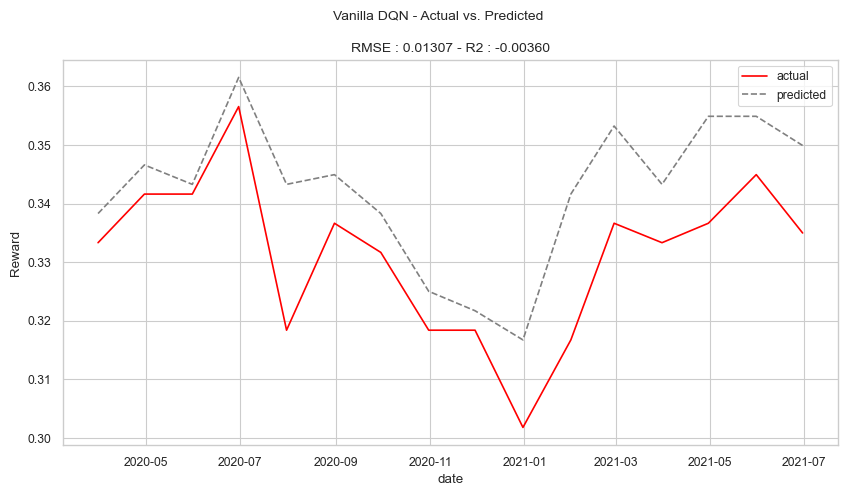

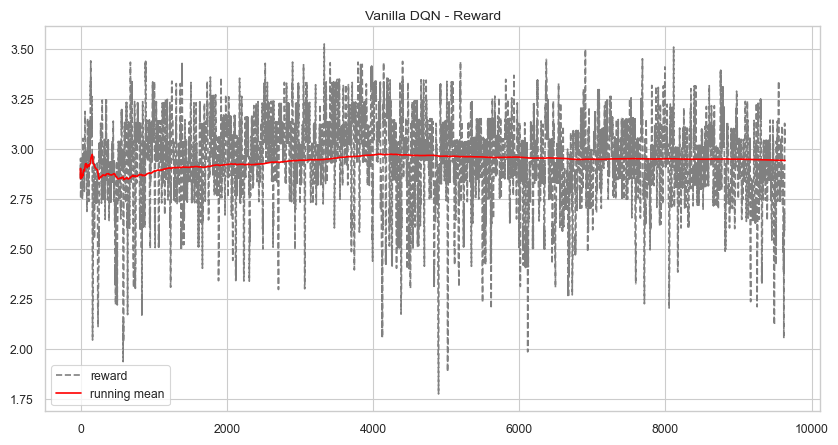

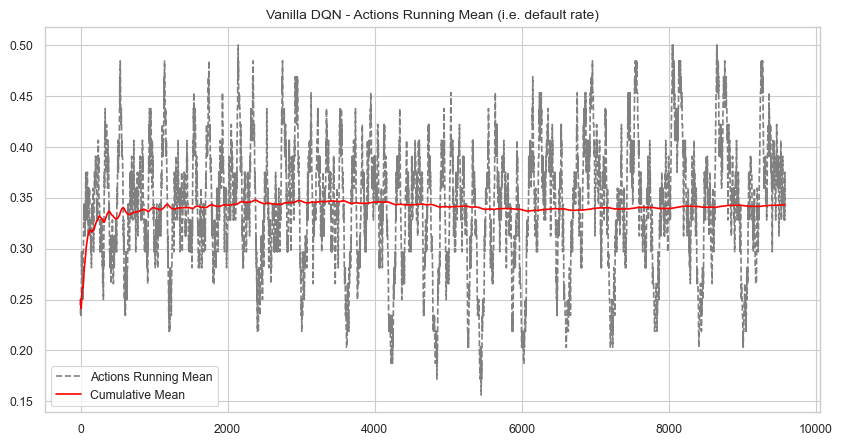

In [197]:
plot_default_rate_history(date_codes = date_codes,
                         actual = train_subset[default_col], 
                         actions = act_dqn,
                         dates_from_codes = dates_from_codes,
                         save_path="../imgs/2_modeling/dfr_history_dqn.png",
                         title = "Vanilla DQN - Actual vs. Predicted")

plot_reward_history(reward = rew_dqn,
                    window_size=10,
                    save_path="../imgs/2_modeling/rew_history_dqn.png",
                    title = "Vanilla DQN - Reward")

plot_actions_running_mean(window_size=64,
                          actions=act_dqn,
                          save_path="../imgs/2_modeling/act_run_mean_dqn.png",
                          title="Vanilla DQN - Actions Running Mean (i.e. default rate)")

In [198]:
print("-"*30)
print(pd.DataFrame(confusion_matrix(train_subset[default_col].values, act_dqn), columns=["True 0", "True 1"], index=["Pred 0", "Pred 1"]))
print("-"*30)
print(classification_report(train_subset[default_col].values, act_dqn))


------------------------------
        True 0  True 1
Pred 0    6341     110
Pred 1       4    3193
------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      6451
         1.0       0.97      1.00      0.98      3197

    accuracy                           0.99      9648
   macro avg       0.98      0.99      0.99      9648
weighted avg       0.99      0.99      0.99      9648



# A2C

In [205]:
kwargs = {
    'features_col': features, # feature colums
    'default_col': 'default_120_12m', # default column
    'obs_dim': len(features),
    'action_dim' : 2,  # 0,1
    'client_dim': len(train_subset.loc[0].index.unique()), # number of clients
    'model_name': "test"
}

num_envs = 2
env_fns = [lambda : CustomEnv(train_subset, debug=True, scaled_features=SCALE, seed=SEED,rng=rng, accepts_discrete_action=True, **kwargs)for i in range(num_envs)]
training_env = SubprocVecEnv(env_fns)
log_path = "logs/binary/a2c"
logger = create_logger(log_path)

In [206]:
feature_extractor = GRUNetwork
# Now use the custom network in policy_kwargs


policy_kwargs = dict(
    features_extractor_class=feature_extractor,
    features_extractor_kwargs=dict(first_layer=400,
                                   first_layer_dropout=0.1,
                                   output_layer=400,
                                   output_layer_dropout=0.1)
)
model_a2c = A2C("MlpPolicy", 
                training_env, 
                verbose=0, 
                device="cpu", 
                learning_rate=1e-3, 
                gamma=0.9,
                seed=SEED,
                n_steps= 128,
                ent_coef=0.02, 
                policy_kwargs=policy_kwargs
                )

model_a2c.set_logger(logger)
model_a2c.learn(LEARNING_STEPS*num_envs*2, log_interval=1)
model_a2c.save("output/binary/a2c")

default: 0.333 - penalty: -1.89 reward:  2.64 - client:  207.0 month:   1 - done: True
default: 0.333 - penalty: -1.78 reward:  2.65 - client:  207.0 month:   1 - done: True
default: 0.342 - penalty: -1.95 reward: -2.63 - client:  394.0 month:   2 - done: True
default: 0.342 - penalty: -2.00 reward: -2.64 - client:  394.0 month:   2 - done: True
default: 0.342 - penalty: -1.98 reward:  3.59 - client:  470.0 month:   3 - done: True
default: 0.342 - penalty: -1.91 reward: -2.62 - client:  470.0 month:   3 - done: True
default: 0.357 - penalty: -2.03 reward:  3.52 - client:  588.0 month:   4 - done: True
default: 0.357 - penalty: -1.96 reward:  3.53 - client:  588.0 month:   4 - done: True
default: 0.318 - penalty: -1.82 reward:  2.71 - client:   26.0 month:   5 - done: True
default: 0.318 - penalty: -1.75 reward:  2.73 - client:   26.0 month:   5 - done: True
default: 0.337 - penalty: -1.71 reward:  2.65 - client:  375.0 month:   6 - done: True
default: 0.337 - penalty: -1.75 reward:  2.

In [207]:
n_steps = len(train_subset)
rew_a2c, _ = predict_from_env(model_a2c, training_env, n_steps)
act_a2c, date_codes = predict_from_frame(model_a2c, train_subset[features])

action: [1 1] - reward : [3.60428888 3.60428888] - done: [False False]
action: [1 1] - reward : [3.60744913 3.60744913] - done: [False False]
action: [1 1] - reward : [3.61441258 3.61441258] - done: [False False]
action: [0 0] - reward : [2.61506585 2.61506585] - done: [False False]
action: [1 1] - reward : [3.61193095 3.61193095] - done: [False False]
action: [0 0] - reward : [2.62447886 2.62447886] - done: [False False]
default: 0.342 - penalty: -1.76 reward:  2.62 - client:  206.0 month:   3 - done: True
default: 0.342 - penalty: -1.76 reward:  2.62 - client:  206.0 month:   3 - done: True
action: [0 0] - reward : [2.5340021 2.5340021] - done: [False False]
action: [0 0] - reward : [2.54522853 2.54522853] - done: [False False]
action: [0 0] - reward : [2.53512208 2.53512208] - done: [False False]
action: [0 0] - reward : [2.5426173 2.5426173] - done: [False False]
action: [1 1] - reward : [3.5383097 3.5383097] - done: [False False]
action: [0 0] - reward : [2.5302361 2.5302361] - do

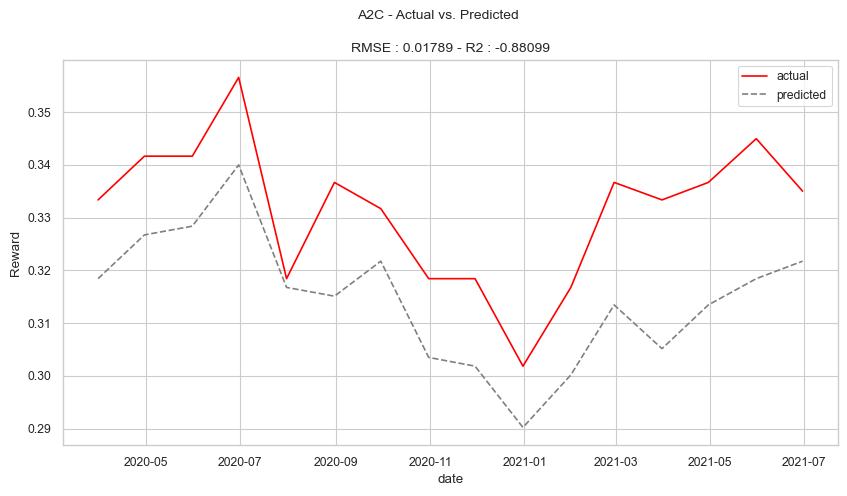

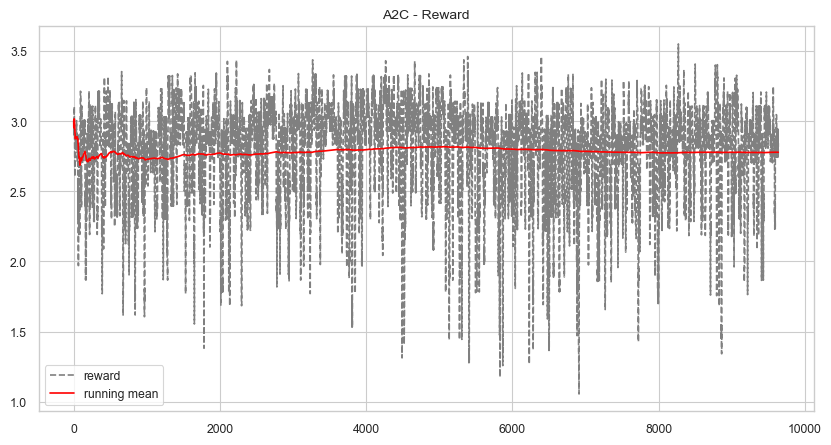

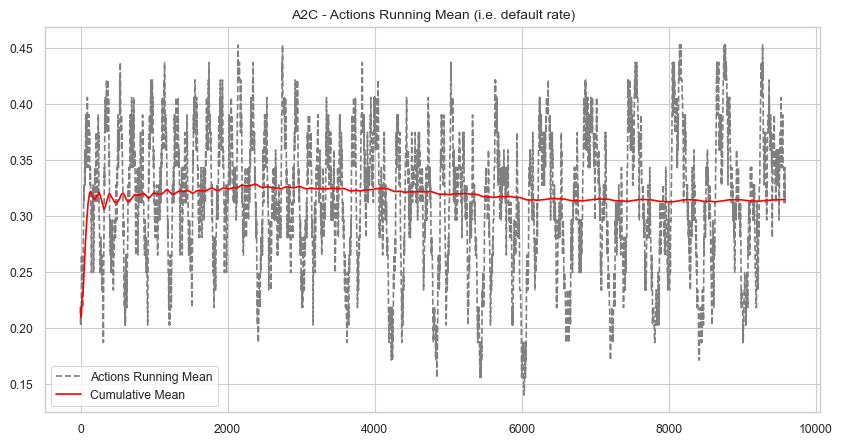

In [208]:

plot_default_rate_history(date_codes = date_codes,
                         actual = train_subset[default_col], 
                         actions = act_a2c,
                         dates_from_codes = dates_from_codes, 
                         title = "A2C - Actual vs. Predicted",
                         save_path="../imgs/2_modeling/dfr_history_a2c.png")

plot_reward_history(reward = rew_a2c,
                    window_size=10,
                    title = "A2C - Reward",
                    save_path="../imgs/2_modeling/rew_history_a2c.png")

plot_actions_running_mean(actions=act_a2c,
                          window_size=64,
                          title="A2C - Actions Running Mean (i.e. default rate)",
                          save_path="../imgs/2_modeling/act_run_mean_a2c.png")

In [209]:
print("-"*30)
print(pd.DataFrame(confusion_matrix(train_subset[default_col].values, act_a2c), columns=["True 0", "True 1"], index=["Pred 0", "Pred 1"]))
print("-"*30)
print(classification_report(train_subset[default_col].values, act_a2c))

------------------------------
        True 0  True 1
Pred 0    6347     104
Pred 1     265    2932
------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      6451
         1.0       0.97      0.92      0.94      3197

    accuracy                           0.96      9648
   macro avg       0.96      0.95      0.96      9648
weighted avg       0.96      0.96      0.96      9648



# TRPO

In [210]:
kwargs = {
    'features_col': features, # feature colums
    'default_col': 'default_120_12m', # default column
    'obs_dim': len(features),
    'action_dim' : 2,  # 0,1
    'client_dim': len(train_subset.loc[0].index.unique()), # number of clients
    'model_name': "test"
}

num_envs = 1
env_fns = [lambda : CustomEnv(train_subset, debug=True, scaled_features=SCALE, seed=SEED,rng=rng, accepts_discrete_action=True, **kwargs)for i in range(num_envs)]
training_env = SubprocVecEnv(env_fns)
log_path = "logs/binary/trpo"
logger = create_logger(log_path)


In [212]:

feature_extractor = GRUNetwork
# Now use the custom network in policy_kwargs
policy_kwargs = dict(
    features_extractor_class=feature_extractor,
    features_extractor_kwargs=dict(first_layer=400,
                                   first_layer_dropout=0.3,
                                   output_layer=400,
                                   output_layer_dropout=0.1)
)

model_trpo = TRPO("MlpPolicy",
                 training_env, 
                 verbose=0,
                 seed = SEED,
                 device="cpu",
                 learning_rate=1e-3,
                 batch_size=64,
                 n_steps=1024,#4096, 2048
                 gamma=0.9,
                 policy_kwargs=policy_kwargs
                 )

model_trpo.set_logger(logger)
model_trpo.learn(LEARNING_STEPS*num_envs*2,log_interval=1)
model_trpo.save("output/binary/trpo")


default: 0.342 - penalty: -1.73 reward:  3.63 - client:  359.0 month:   2 - done: True
default: 0.342 - penalty: -1.81 reward: -1.61 - client:   13.0 month:   3 - done: True
default: 0.357 - penalty: -1.82 reward:  2.56 - client:  158.0 month:   4 - done: True
default: 0.318 - penalty: -1.65 reward: -2.56 - client:  250.0 month:   5 - done: True
default: 0.337 - penalty: -1.82 reward:  2.63 - client:  399.0 month:   6 - done: True
default: 0.332 - penalty: -1.67 reward: -1.58 - client:  273.0 month:   7 - done: True
default: 0.318 - penalty: -1.66 reward:  3.74 - client:  271.0 month:   8 - done: True
default: 0.318 - penalty: -1.61 reward:  2.75 - client:  441.0 month:   9 - done: True
default: 0.302 - penalty: -1.54 reward:  2.84 - client:  384.0 month:  10 - done: True
default: 0.317 - penalty: -1.61 reward:  3.76 - client:  456.0 month:  11 - done: True
default: 0.337 - penalty: -1.77 reward: -1.60 - client:   22.0 month:  12 - done: True
default: 0.333 - penalty: -1.78 reward:  3.

In [213]:
n_steps = len(train_subset)
rew_trpo, _ = predict_from_env(model_trpo, training_env, n_steps)
act_trpo, date_codes = predict_from_frame(model_trpo, train_subset[features])

action: [1] - reward : [3.74046111] - done: [False]
action: [0] - reward : [2.73727375] - done: [False]
action: [0] - reward : [2.73024348] - done: [False]
action: [1] - reward : [3.7310279] - done: [False]
action: [0] - reward : [2.73417177] - done: [False]
action: [0] - reward : [2.72555213] - done: [False]
default: 0.318 - penalty: -1.75 reward:  2.73 - client:  513.0 month:   5 - done: True
action: [0] - reward : [2.63296782] - done: [False]
action: [1] - reward : [3.62752885] - done: [False]
action: [1] - reward : [3.63838079] - done: [False]
action: [0] - reward : [2.63273329] - done: [False]
action: [1] - reward : [3.62343256] - done: [False]
action: [1] - reward : [3.63679756] - done: [False]
default: 0.337 - penalty: -1.82 reward:  2.64 - client:   93.0 month:   6 - done: True
action: [0] - reward : [2.67345971] - done: [False]
action: [0] - reward : [-2.59699179] - done: [False]
action: [0] - reward : [-2.59999364] - done: [False]
action: [0] - reward : [2.65937694] - done: [

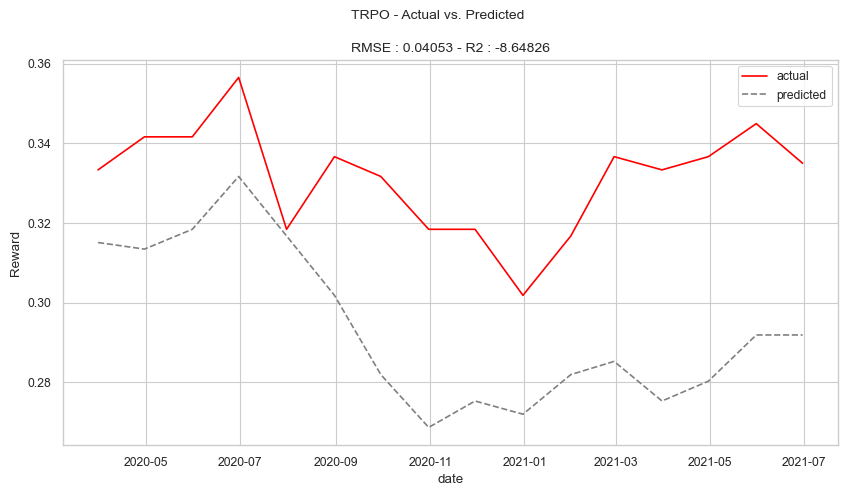

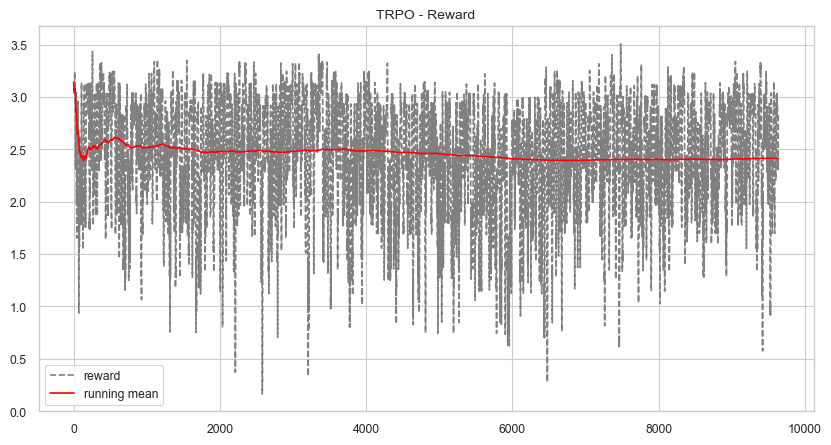

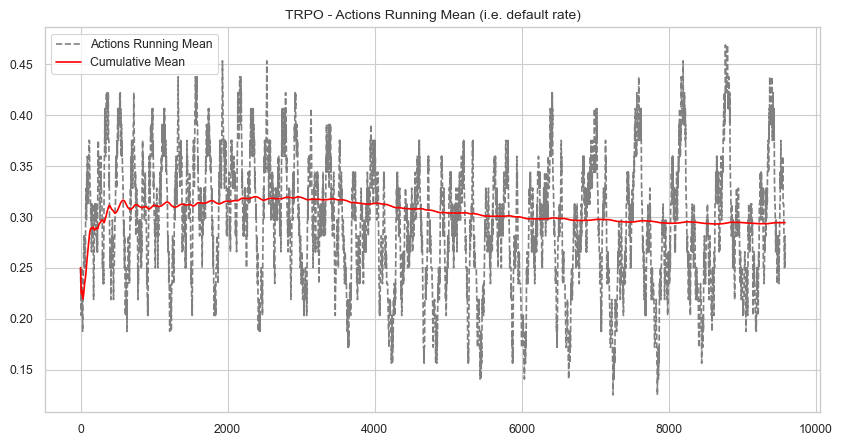

In [214]:
plot_default_rate_history(date_codes = date_codes,
                         actual = train_subset[default_col], 
                         actions = act_trpo,
                         dates_from_codes = dates_from_codes,
                         save_path="../imgs/2_modeling/dfr_history_trpo.png",
                         title = "TRPO - Actual vs. Predicted")

plot_reward_history(reward = rew_trpo,
                    window_size=10,
                    save_path="../imgs/2_modeling/rew_history_trpo.png",
                    title = "TRPO - Reward")

plot_actions_running_mean(actions=act_trpo,
                          window_size=64,
                          save_path="../imgs/2_modeling/act_run_mean_trpo.png",
                          title="TRPO - Actions Running Mean (i.e. default rate)")

In [215]:
print("-"*30)
print(pd.DataFrame(confusion_matrix(train_subset[default_col].values, act_trpo), columns=["True 0", "True 1"], index=["Pred 0", "Pred 1"]))
print("-"*30)
print(classification_report(train_subset[default_col].values, act_trpo))

------------------------------
        True 0  True 1
Pred 0    6113     338
Pred 1     700    2497
------------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92      6451
         1.0       0.88      0.78      0.83      3197

    accuracy                           0.89      9648
   macro avg       0.89      0.86      0.87      9648
weighted avg       0.89      0.89      0.89      9648



# PPO

In [221]:
kwargs = {
    'features_col': features, # feature colums
    'default_col': 'default_120_12m', # default column
    'obs_dim': len(features),
    'action_dim' : 2,  # 0,1
    'client_dim': len(train_subset.loc[0].index.unique()), # number of clients
    'model_name': "test"
}

num_envs = 1
env_fns = [lambda : CustomEnv(train_subset, debug=True, scaled_features=SCALE, seed=SEED,rng=rng, accepts_discrete_action=True, **kwargs)for i in range(num_envs)]
training_env = SubprocVecEnv(env_fns)
log_path = "logs/binary/ppo"
logger = create_logger(log_path)

In [222]:
feature_extractor = GRUNetwork
# Now use the custom network in policy_kwargs
policy_kwargs = dict(
    features_extractor_class=feature_extractor,
    features_extractor_kwargs=dict(first_layer=400,
                                   first_layer_dropout=0.3,
                                   output_layer=400,
                                   output_layer_dropout=0.1)
)

model_ppo = TRPO("MlpPolicy",
                 training_env, 
                 verbose=0,
                 seed = SEED,
                 device="cpu",
                 learning_rate=1e-3,
                 batch_size=64,
                 n_steps=1024-10,#4096, 2048
                 gamma=0.9,
                 policy_kwargs=policy_kwargs
                 )

model_ppo.set_logger(logger)
_ = training_env.reset()
model_ppo.learn(LEARNING_STEPS*num_envs*2,log_interval=1)
model_ppo.save("output/binary/ppo")

default: 0.333 - penalty: -1.60 reward:  2.68 - client:  207.0 month:   1 - done: True
default: 0.342 - penalty: -1.79 reward:  3.62 - client:  394.0 month:   2 - done: True
default: 0.342 - penalty: -1.78 reward:  3.62 - client:  470.0 month:   3 - done: True
default: 0.357 - penalty: -1.82 reward:  3.56 - client:  588.0 month:   4 - done: True
default: 0.318 - penalty: -1.66 reward: -1.56 - client:   26.0 month:   5 - done: True
default: 0.337 - penalty: -1.64 reward:  2.66 - client:  375.0 month:   6 - done: True
default: 0.332 - penalty: -1.73 reward:  2.67 - client:  191.0 month:   7 - done: True
default: 0.318 - penalty: -1.66 reward: -1.56 - client:  366.0 month:   8 - done: True
default: 0.318 - penalty: -1.57 reward:  2.75 - client:  248.0 month:   9 - done: True
default: 0.302 - penalty: -1.46 reward: -1.52 - client:  139.0 month:  10 - done: True
default: 0.317 - penalty: -1.65 reward:  2.75 - client:  528.0 month:  11 - done: True
default: 0.337 - penalty: -1.65 reward:  3.

In [223]:
n_steps = len(train_subset)
rew_ppo, _ = predict_from_env(model_ppo, training_env, n_steps)
act_ppo, date_codes = predict_from_frame(model_ppo, train_subset[features])

action: [0] - reward : [2.55845131] - done: [False]
action: [0] - reward : [2.53034227] - done: [False]
default: 0.357 - penalty: -1.96 reward:  3.53 - client:  218.0 month:   4 - done: True
action: [0] - reward : [2.6930331] - done: [False]
action: [0] - reward : [2.72948953] - done: [False]
action: [0] - reward : [2.72394682] - done: [False]
action: [0] - reward : [2.72867948] - done: [False]
action: [0] - reward : [2.71921061] - done: [False]
action: [0] - reward : [2.74350608] - done: [False]
default: 0.318 - penalty: -1.69 reward:  2.74 - client:  426.0 month:   5 - done: True
action: [0] - reward : [2.65638267] - done: [False]
action: [0] - reward : [2.62502145] - done: [False]
action: [1] - reward : [3.64376843] - done: [False]
action: [0] - reward : [2.62114502] - done: [False]
action: [1] - reward : [3.64154776] - done: [False]
action: [0] - reward : [2.63363164] - done: [False]
default: 0.337 - penalty: -1.81 reward:  2.64 - client:  238.0 month:   6 - done: True
action: [1] 

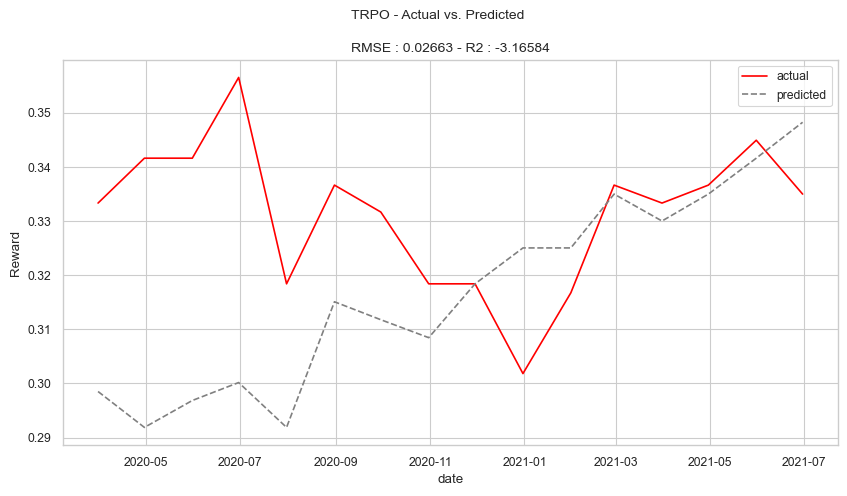

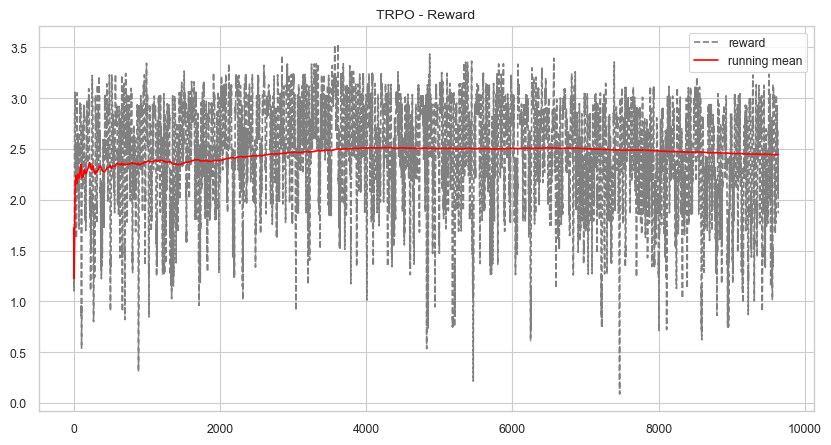

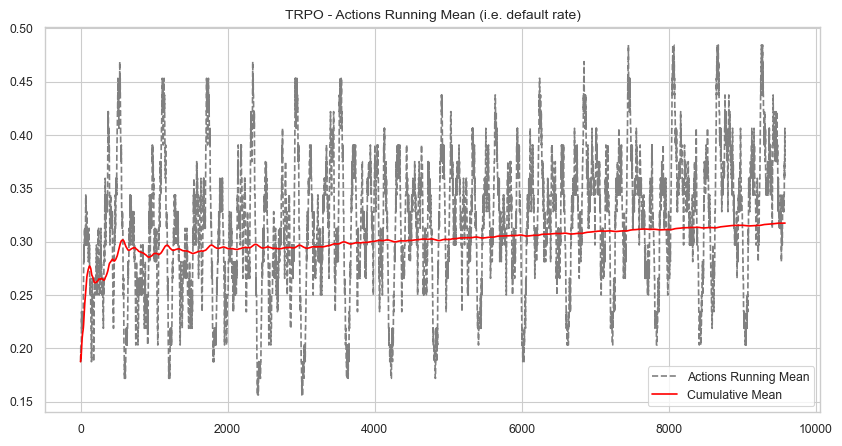

In [224]:
plot_default_rate_history(date_codes = date_codes,
                         actual = train_subset[default_col], 
                         actions = act_ppo,
                         dates_from_codes = dates_from_codes,
                         save_path="../imgs/2_modeling/dfr_history_ppo.png",
                         title = "TRPO - Actual vs. Predicted")

plot_reward_history(reward = rew_ppo,
                    window_size=10,
                    save_path="../imgs/2_modeling/rew_history_ppo.png",
                    title = "TRPO - Reward")

plot_actions_running_mean(actions=act_ppo,
                          window_size=64,
                          save_path="../imgs/2_modeling/act_run_mean_ppo.png",
                          title="TRPO - Actions Running Mean (i.e. default rate)")

In [226]:
print("-"*30)
print(pd.DataFrame(confusion_matrix(train_subset[default_col].values, act_ppo), columns=["True 0", "True 1"], index=["Pred 0", "Pred 1"]))
print("-"*30)
print(classification_report(train_subset[default_col].values, act_ppo))

------------------------------
        True 0  True 1
Pred 0    6047     404
Pred 1     542    2655
------------------------------
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93      6451
         1.0       0.87      0.83      0.85      3197

    accuracy                           0.90      9648
   macro avg       0.89      0.88      0.89      9648
weighted avg       0.90      0.90      0.90      9648



# Gradient Boosting (Baseline)

In [227]:
# stage 1: prediction
model_gb = HistGradientBoostingClassifier(max_iter=12)
model_gb.fit(train_subset[features], train_subset[default_col])
probs_gb = model_gb.predict_proba(train_subset[features])

In [228]:
# stage 2: classification
act_gb = np.where(probs_gb[:,1]>=0.5, 1, 0) # <- needs tunning 0.5 

print(classification_report(train_subset[default_col], act_gb))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6451
         1.0       1.00      1.00      1.00      3197

    accuracy                           1.00      9648
   macro avg       1.00      1.00      1.00      9648
weighted avg       1.00      1.00      1.00      9648



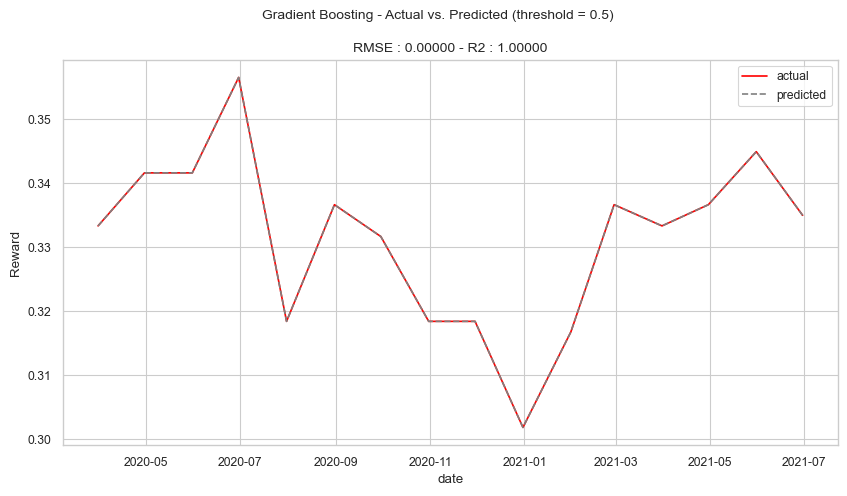

In [229]:
plot_default_rate_history(date_codes = date_codes,
                         actual = train_subset[default_col], 
                         actions = act_gb,
                         dates_from_codes = dates_from_codes,
                         save_path="../imgs/2_modeling/dfr_history_gb.png",
                         title = "Gradient Boosting - Actual vs. Predicted (threshold = 0.5)")

In [230]:
# compute optimal threshold that maximizes r2
optimal_threshold = 0.0
max_r2 = float('-inf')

for threshold in np.linspace(0, 1, 101):
    act_gb = np.where(probs_gb[:,1] >= threshold, 1, 0)
    score = r2_score(train_subset[default_col], act_gb)
    if score > max_r2:
        max_r2 = score
        optimal_threshold = threshold

In [231]:
# stage 2: classification
act_gb = np.where(probs_gb[:,1]>=optimal_threshold, 1, 0) # <- needs tunning 0.5 

print(classification_report(train_subset[default_col], act_gb))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6451
         1.0       1.00      1.00      1.00      3197

    accuracy                           1.00      9648
   macro avg       1.00      1.00      1.00      9648
weighted avg       1.00      1.00      1.00      9648



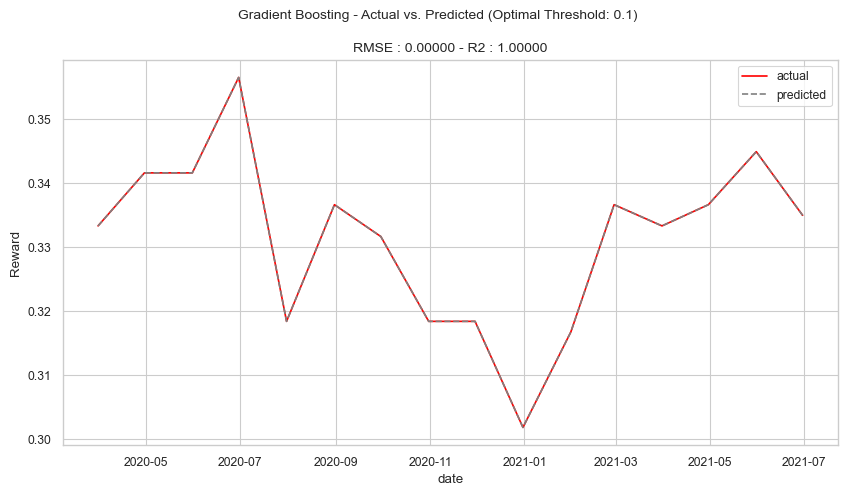

In [232]:
plot_default_rate_history(date_codes = date_codes,
                         actual = train_subset[default_col], 
                         actions = act_gb,
                         dates_from_codes = dates_from_codes, 
                         title = f"Gradient Boosting - Actual vs. Predicted (Optimal Threshold: {optimal_threshold})")

# Compare

In [251]:
default_rate_hisotry = pd.DataFrame({"date":[dates_from_codes[x] for x in date_codes],
              "actual": train_subset[default_col],
              "dqn":act_dqn,
              "doubledqn":act_ddqn,
              "dueldqn":act_dueldqn,
              "a2c":act_a2c,
              "trpo":act_trpo,
              "ppo":act_ppo,
              }).groupby("date").mean()

In [252]:
default_rate_hisotry

actual       dqn  doubledqn   dueldqn       a2c      trpo  \
date                                                                      
2020-03-31  0.333333  0.338308   0.333333  0.333333  0.318408  0.315091   
2020-04-30  0.341625  0.346600   0.343284  0.341625  0.326700  0.313433   
2020-05-31  0.341625  0.343284   0.341625  0.341625  0.328358  0.318408   
2020-06-30  0.356551  0.361526   0.361526  0.358209  0.339967  0.331675   
2020-07-31  0.318408  0.343284   0.341625  0.334992  0.316750  0.316750   
2020-08-31  0.336650  0.344942   0.351575  0.343284  0.315091  0.301824   
2020-09-30  0.331675  0.338308   0.341625  0.334992  0.321725  0.281924   
2020-10-31  0.318408  0.325041   0.328358  0.320066  0.303483  0.268657   
2020-11-30  0.318408  0.321725   0.321725  0.320066  0.301824  0.275290   
2020-12-31  0.301824  0.316750   0.315091  0.311774  0.290216  0.271973   
2021-01-31  0.316750  0.341625   0.336650  0.331675  0.300166  0.281924   
2021-02-28  0.336650  0.353234   0.338308  0.339967  0.313433  0.285240   
2021-03-31  0.333333  0.343284   0.343284  0.338308  0.305141  0.275290   
2021-04-30  0.336650  0.354892   0.346600  0.339967  0.313433  0.280265   
2021-05-31  0.344942  0.354892   0.351575  0.348259  0.318408  0.291874   
2021-06-30  0.334992  0.349917   0.346600  0.349917  0.321725  0.291874   

                 ppo  
date                  
2020-03-31  0.298507  
2020-04-30  0.291874  
2020-05-31  0.296849  
2020-06-30  0.300166  
2020-07-31  0.291874  
2020-08-31  0.315091  
2020-09-30  0.311774  
2020-10-31  0.308458  
2020-11-30  0.318408  
2020-12-31  0.325041  
2021-01-31  0.325041  
2021-02-28  0.334992  
2021-03-31  0.330017  
2021-04-30  0.334992  
2021-05-31  0.341625  
2021-06-30  0.348259

In [586]:
err_results = []

# Iterate over the columns in the DataFrame
for model in default_rate_hisotry.columns.drop('actual'):
    # Calculate RMSE
    rmse = mean_squared_error(default_rate_hisotry['actual'], default_rate_hisotry[model], squared=False)
    #mean absolute error
    mae = mean_absolute_error(default_rate_hisotry['actual'], default_rate_hisotry[model])

    # Calculate R2 score
    r2 = r2_score(default_rate_hisotry['actual'], default_rate_hisotry[model])

    # Append the results to the list
    err_results.append({'model': model, 'r2': r2, 'mae': mae})

# Convert the list of results to a DataFrame
results_df = pd.DataFrame(err_results)
# results_df.sort_values(by="rmse", ascending=True)
results_df.sort_values(by="r2", ascending=False)

model        r2       mae
2    dueldqn  0.654698  0.005390
1  doubledqn  0.284155  0.008810
0        dqn -0.003597  0.010987
3        a2c -0.880987  0.016687
5        ppo -3.165836  0.019900
4       trpo -8.648262  0.037521

In [584]:
default_rate_hisotry

actual       dqn  doubledqn   dueldqn       a2c      trpo  \
date                                                                      
2020-03-31  0.333333  0.338308   0.333333  0.333333  0.318408  0.315091   
2020-04-30  0.341625  0.346600   0.343284  0.341625  0.326700  0.313433   
2020-05-31  0.341625  0.343284   0.341625  0.341625  0.328358  0.318408   
2020-06-30  0.356551  0.361526   0.361526  0.358209  0.339967  0.331675   
2020-07-31  0.318408  0.343284   0.341625  0.334992  0.316750  0.316750   
2020-08-31  0.336650  0.344942   0.351575  0.343284  0.315091  0.301824   
2020-09-30  0.331675  0.338308   0.341625  0.334992  0.321725  0.281924   
2020-10-31  0.318408  0.325041   0.328358  0.320066  0.303483  0.268657   
2020-11-30  0.318408  0.321725   0.321725  0.320066  0.301824  0.275290   
2020-12-31  0.301824  0.316750   0.315091  0.311774  0.290216  0.271973   
2021-01-31  0.316750  0.341625   0.336650  0.331675  0.300166  0.281924   
2021-02-28  0.336650  0.353234   0.338308  0.339967  0.313433  0.285240   
2021-03-31  0.333333  0.343284   0.343284  0.338308  0.305141  0.275290   
2021-04-30  0.336650  0.354892   0.346600  0.339967  0.313433  0.280265   
2021-05-31  0.344942  0.354892   0.351575  0.348259  0.318408  0.291874   
2021-06-30  0.334992  0.349917   0.346600  0.349917  0.321725  0.291874   

                 ppo  
date                  
2020-03-31  0.298507  
2020-04-30  0.291874  
2020-05-31  0.296849  
2020-06-30  0.300166  
2020-07-31  0.291874  
2020-08-31  0.315091  
2020-09-30  0.311774  
2020-10-31  0.308458  
2020-11-30  0.318408  
2020-12-31  0.325041  
2021-01-31  0.325041  
2021-02-28  0.334992  
2021-03-31  0.330017  
2021-04-30  0.334992  
2021-05-31  0.341625  
2021-06-30  0.348259

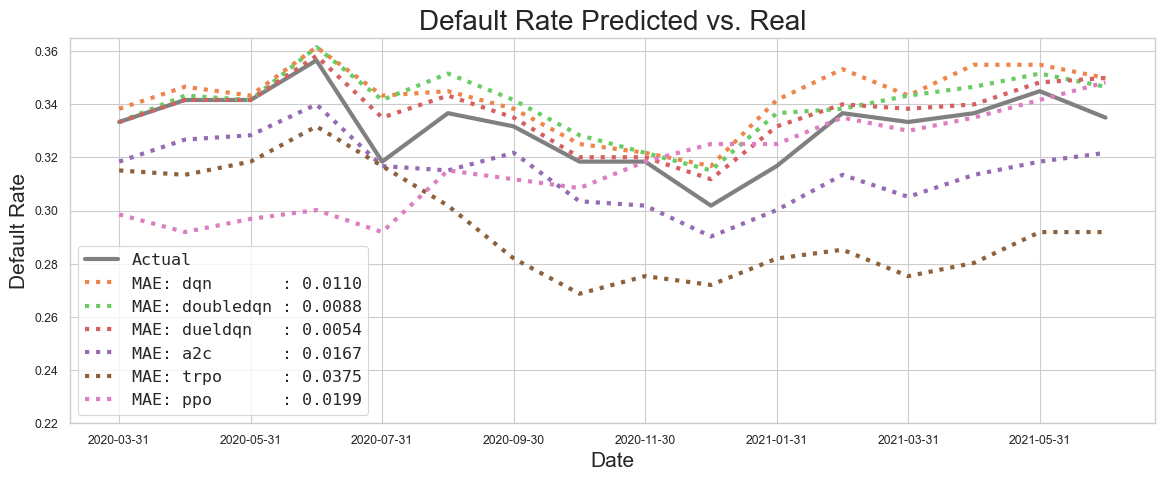

In [792]:
ax = default_rate_hisotry.plot(figsize=(14, 5))

# Set line styles and colors
ax.lines[0].set_linestyle("-")
ax.lines[0].set_color("gray")
ax.lines[0].set_linewidth(3)
[x.set_linestyle(':') for x in ax.lines[1:]]
[x.set_linewidth(3) for x in ax.lines]

# Find the longest string length for model names
longest_model_name = max(len(model) for model in results_df.model)

# Find the maximum length of the MAE strings to align the decimal points
max_mae_length = max(len(f"{mae:.4f}") for mae in results_df.mae)

# Create legend labels with padded model names and aligned MAE values
legend_labels = ['Actual'] + [
    f"MAE: {model}{' '*(longest_model_name - len(model))} : {mae:>{max_mae_length}.4f}"
    for model, mae in zip(results_df.model, results_df.mae)
]

# Set legend with formatted labels using a monospaced font
ax.legend(legend_labels, loc='lower left', prop={'family': 'monospace', 'size': 12})

plt.title("Default Rate Predicted vs. Real", fontsize=20)
plt.ylabel("Default Rate", fontsize=15)
plt.xlabel("Date", fontsize=15)
# Set minimum y axis
plt.ylim(0.22, 0.365)
# Save figure before calling show()
plt.savefig("../imgs/2_modeling/predicted_vs_real_all.png", dpi=300)

# Show the plot
plt.show()

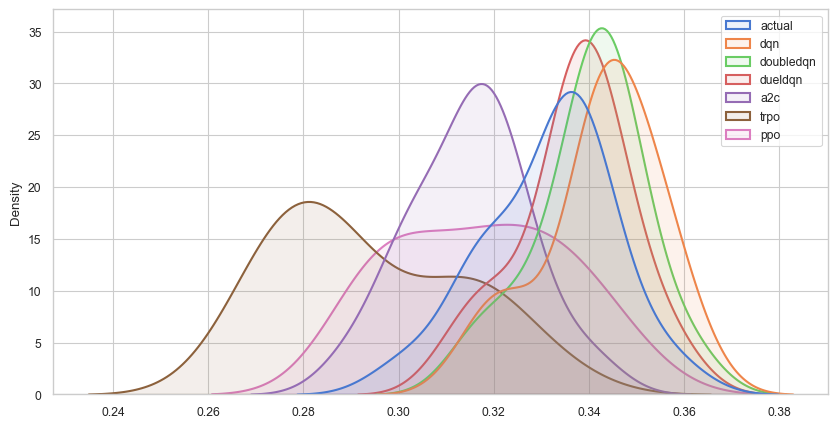

In [304]:
plt.figure(figsize=(10, 5))
ax = sns.kdeplot(data=default_rate_hisotry, shade=True, legend=True, common_norm=False, fill=True, linewidth=1.5, alpha=0.1)
plt.savefig("../imgs/2_modeling/default_rate_distribution_all.png", dpi=300)
#set dashed lines in sns.kdeplot(data=default_Rate_hisotry)


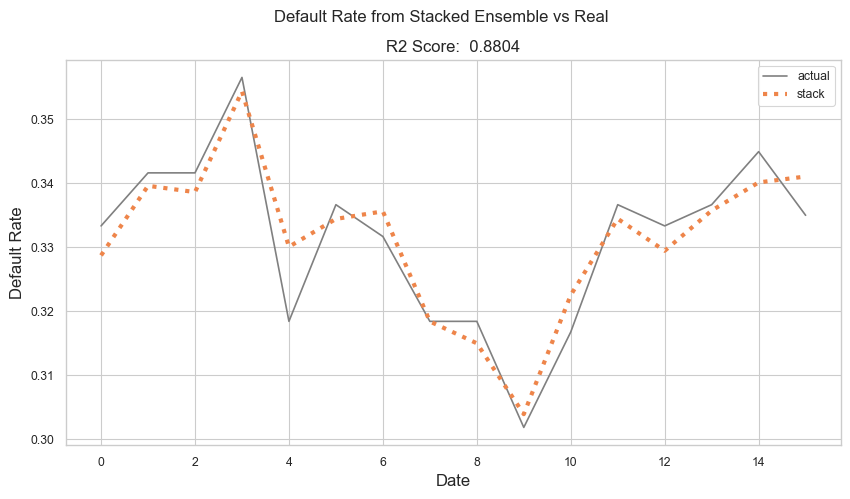

In [303]:
from sklearn.linear_model import Ridge, Lasso

model_ridge = Ridge(alpha=1e-4, fit_intercept=False, max_iter=1_000)
X_ensemble = default_rate_hisotry[["dqn", "doubledqn", "dueldqn", "a2c", "trpo", "ppo"]]
y_ensemble = default_rate_hisotry["actual"]
model_ridge.fit(X_ensemble,y_ensemble)
y_ensemble_pred = model_ridge.predict(X_ensemble)




a = pd.DataFrame({"date_codes":date_codes,
              "actual": train_subset[default_col],
            #   "dqn":act_dqn,
            #   "doubledqn":act_ddqn,
            #   "dueldqn":act_dueldqn,
            #   "a2c":act_a2c,
            #   "trpo":act_trpo,
            #   "ppo":act_ppo,
              # "gb":act_gb,
              # "mean" : np.quantile([act_dqn, act_ddqn, act_dueldqn, act_a2c, act_trpo, act_ppo], q=0.525, axis=0),
              }).groupby("date_codes").mean()

ax = a.plot(figsize=(10, 5),)
ax.plot(a.index, y_ensemble_pred, label="stack")
ax.lines[0].set_color("gray")
ax.lines[1].set_linestyle(":")
ax.lines[1].set_linewidth(3)
plt.legend()

# Set R2 score as title
plt.suptitle("Default Rate from Stacked Ensemble vs Real", fontsize=12)
plt.title(f"R2 Score: {r2_score(y_ensemble, y_ensemble_pred): .4f}", fontsize=12)
plt.ylabel("Default Rate", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.savefig("../imgs/2_modeling/default_rate_history Ensemble.png", dpi=300)


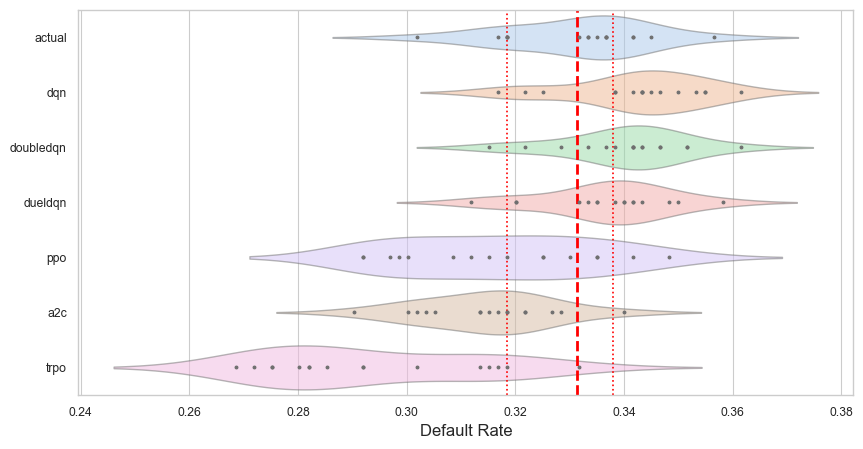

In [877]:
# plot vivolin plot using seaborn for all models in resb
plt.figure(figsize=(10, 5))
sns.violinplot(data=default_rate_hisotry[['actual','dqn', 'doubledqn', 'dueldqn', 'ppo', 'a2c', 'trpo']], alpha=0.5, palette="pastel", inner="point", orient="h")
plt.xlabel("Default Rate", fontsize=12)
plt.axvline(x=default_rate_hisotry.actual.mean(), color="red", linestyle="dashed", linewidth=2, label="zero")
plt.axvline(x=default_rate_hisotry.actual.quantile(.75), color="red", linestyle=":", label="zero")
plt.axvline(x=default_rate_hisotry.actual.quantile(.25), color="red", linestyle=":", label="zero")

plt.savefig("../imgs/2_modeling/default_rate_violin_all.png", dpi=300)


In [307]:
error = default_rate_hisotry.subtract(default_rate_hisotry["actual"], axis=0).drop("actual", axis=1)

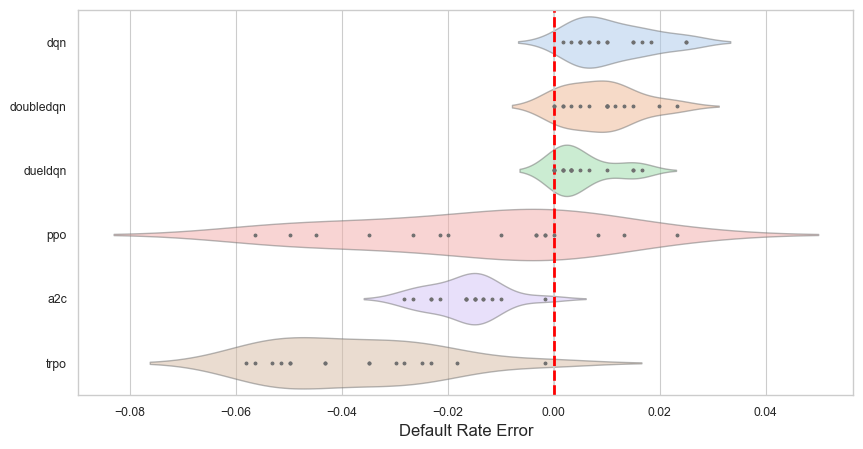

In [875]:
plt.figure(figsize=(10, 5))
sns.violinplot(data=error[list(error.mean().sort_values().index)[::-1]], alpha=0.5,  palette="pastel", inner="point", orient="h")
plt.axvline(x=0, color="lightgray", linestyle="-", label="zero")
plt.xlabel("Default Rate Error", fontsize=12)
plt.axvline(x=0, color="red", linestyle="dashed", linewidth=2, label="zero")
plt.savefig("../imgs/2_modeling/default_rate_error_violin_all.png", dpi=300)

In [311]:
folder_path = 'logs/binary/'
progress_csv = get_csv_files(folder_path)

In [313]:
df_progress = dict([(x.split('/')[-2], pd.read_csv(x)) for x in progress_csv])

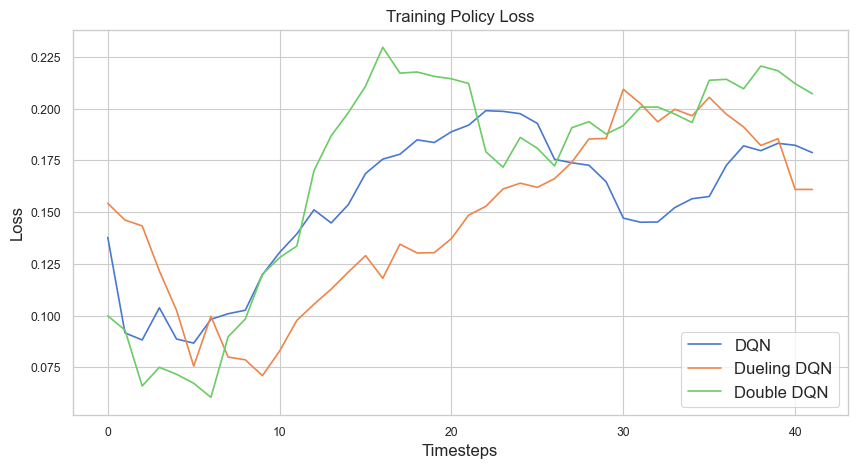

In [704]:
plt.figure(figsize=(10, 5))
plt.plot(running_mean_last_n_samples(df_progress['dqn'][['train/loss']].fillna(0), 10), label="DQN")
plt.plot(running_mean_last_n_samples(df_progress['dueldqn'][['train/loss']].fillna(0), 10), label="Dueling DQN")
plt.plot(running_mean_last_n_samples(df_progress['ddqn'][['train/loss']].fillna(0), 10), label="Double DQN")

plt.title("Training Policy Loss", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.xlabel("Timesteps", fontsize=12)
plt.legend(fontsize=12, loc="lower right")
plt.savefig("../imgs/2_modeling/policy_loss_dqn_family.png", dpi=300)


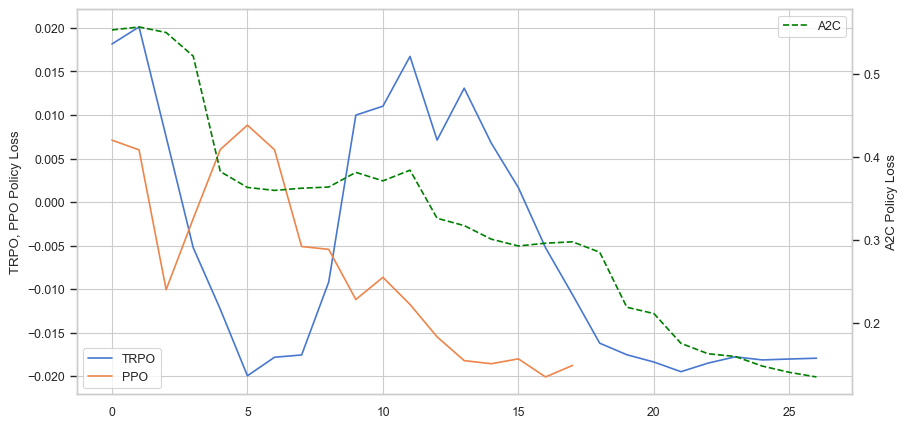

In [797]:
plt.figure(figsize=(10, 5))
ax = plt.gca()
ax.plot(running_mean_last_n_samples(df_progress['trpo']['train/policy_objective'].fillna(0), 3), label='TRPO')
ax.plot(running_mean_last_n_samples(df_progress['ppo']['train/policy_objective'].fillna(0), 3), label='PPO')

# Turn off gridlines for the primary y-axis
ax.grid(True)

# Create a twin axis for the third plot
ax2 = ax.twinx()

# Plot the third line on the secondary y-axis
ax2.plot(running_mean_last_n_samples(df_progress['a2c']['train/policy_loss'].fillna(0), 125), color='green', linestyle='dashed', label='A2C')

# Turn off gridlines for the secondary y-axis
ax2.grid(False)
ax2.set_ylabel("A2C Policy Loss")
ax.set_ylabel("TRPO, PPO Policy Loss")
# Optional: Add legend
ax.legend(loc='lower left')
ax2.legend(loc='upper right')
plt.savefig("../imgs/2_modeling/policy_loss_poligradient_family.png", dpi=300)
# Show the plot
plt.show()

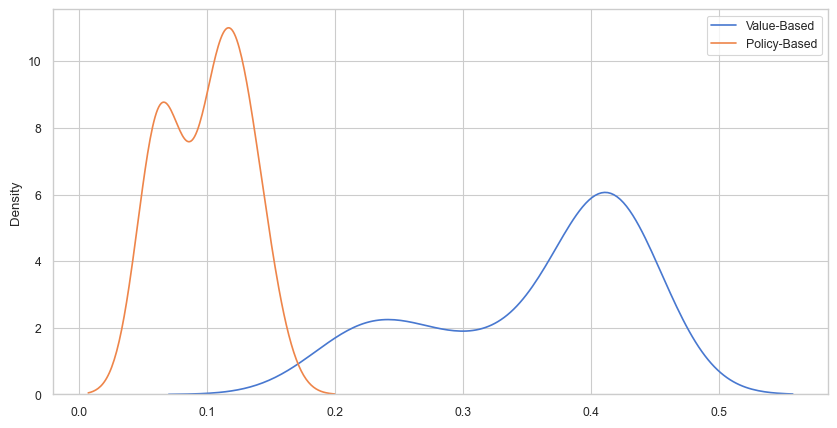

In [934]:
plt.figure(figsize=(10, 5))
sns.kdeplot((running_mean_last_n_samples(df_progress['dqn'][['train/loss']].fillna(0), 10) + running_mean_last_n_samples(df_progress['dueldqn'][['train/loss']].fillna(0), 10) + running_mean_last_n_samples(df_progress['ddqn'][['train/loss']].fillna(0), 10)/3), label="Value-Based")
sns.kdeplot(((running_mean_last_n_samples(df_progress['trpo']['train/policy_objective'].fillna(0), 10) + running_mean_last_n_samples(df_progress['a2c']['train/policy_loss'].fillna(0), 132) + + running_mean_last_n_samples(df_progress['ppo']['train/policy_objective'].fillna(0), 1))/3), label="Policy-Based")
plt.legend()
plt.savefig("../imgs/2_modeling/policy_loss_kde_between_families.png", dpi=300)



Text(0.5, 1.0, 'Smoothed Cumulative Reward')

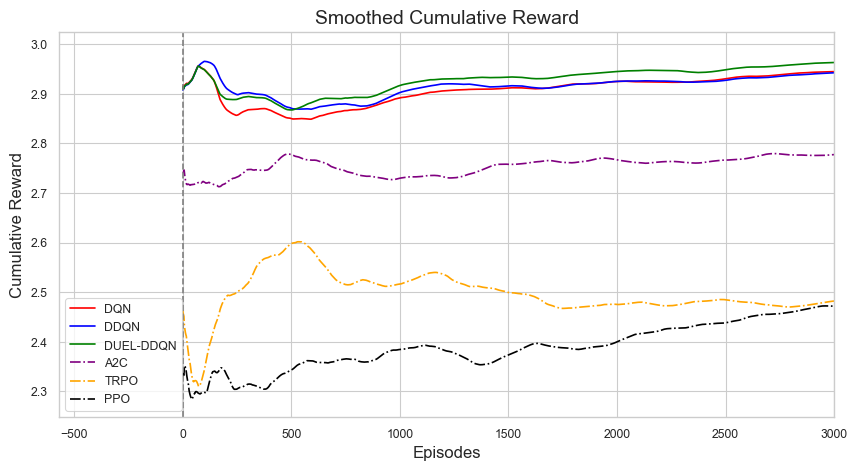

In [857]:
plt.figure(figsize=(10, 5))
W = 100
plt.plot(running_mean_last_n_samples(rew_dqn, W).cumsum()/(np.arange(len(running_mean_last_n_samples(rew_dqn, W).cumsum()))+1) , color="red", linestyle="-")
plt.plot(running_mean_last_n_samples(rew_ddqn, W).cumsum()/(np.arange(len(running_mean_last_n_samples(rew_ddqn, W).cumsum()))+1) , color="blue", linestyle="-")
plt.plot(running_mean_last_n_samples(rew_dueldqn, W).cumsum()/(np.arange(len(running_mean_last_n_samples(rew_dueldqn, W).cumsum()))+1) , color="green", linestyle="-")
plt.plot(running_mean_last_n_samples(rew_a2c, W).cumsum()/(np.arange(len(running_mean_last_n_samples(rew_a2c, W).cumsum()))+1) , color="purple", linestyle="-.")
plt.plot(running_mean_last_n_samples(rew_trpo, W).cumsum()/(np.arange(len(running_mean_last_n_samples(rew_trpo, W).cumsum()))+1) , color="orange", linestyle="-.")
plt.plot(running_mean_last_n_samples(rew_ppo, W).cumsum()/(np.arange(len(running_mean_last_n_samples(rew_ppo, W).cumsum()))+1) , color="black", linestyle="-.")
plt.xlim([-570, 3000])
plt.axvline(0, color="gray", linestyle="--")
plt.legend(["DQN", "DDQN", "DUEL-DDQN", "A2C", "TRPO", "PPO"], loc="lower left")
plt.ylabel("Cumulative Reward", fontsize=12)
plt.xlabel("Episodes", fontsize=12)
plt.savefig("../imgs/2_modeling/smoothed_cumulative_rewards_train.png", dpi=300, bbox_inches='tight')
plt.title("Smoothed Cumulative Reward", fontsize=14)

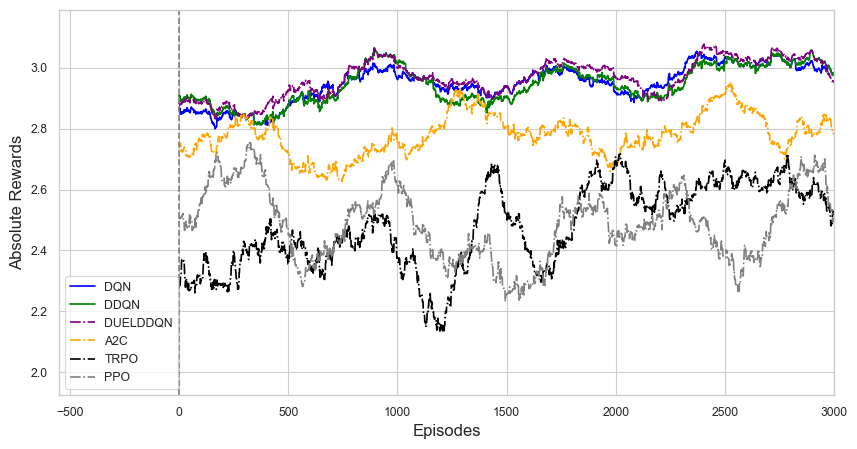

In [855]:
plt.figure(figsize=(10, 5))
plt.plot(running_mean_last_n_samples(rew_dqn, 250) , color="blue", linestyle="-")
plt.plot(running_mean_last_n_samples(rew_ddqn, 250) , color="green", linestyle="-")
plt.plot(running_mean_last_n_samples(rew_dueldqn, 250) , color="purple", linestyle="-.")
plt.plot(running_mean_last_n_samples(rew_a2c, 250) , color="orange", linestyle="-.")
plt.plot(running_mean_last_n_samples(rew_ppo, 250) , color="black", linestyle="-.")
plt.plot(running_mean_last_n_samples(rew_trpo, 250) , color="gray", linestyle="-.")

plt.xlim([-550, 3000])
plt.axvline(0, color="gray", linestyle="--")
plt.ylabel("Absolute Rewards", fontsize=12)
plt.xlabel("Episodes", fontsize=12)
plt.legend(["DQN", "DDQN", "DUELDDQN", "A2C", "TRPO", "PPO"], loc="lower left")
plt.savefig("../imgs/2_modeling/smoothed_absolute_rewards_train.png", dpi=300, bbox_inches='tight')

In [937]:
# print classification report for all test_rew
print("-"*30, "test_dqn_act", "-"*30)
print(classification_report(train_subset.default_120_12m.values, act_dqn))
print("-"*30, "test_ppo_act", "-"*30)
print(classification_report(train_subset.default_120_12m.values, act_ppo))
print("-"*30, "test_a2c_act", "-"*30)
print(classification_report(train_subset.default_120_12m.values, act_a2c))
print("-"*30, "test_trpo_act", "-"*30)
print(classification_report(train_subset.default_120_12m.values, act_trpo))
print("-"*30, "test_ddqn_act", "-"*30)
print(classification_report(train_subset.default_120_12m.values, act_ddqn))
print("-"*30, "test_dueldqn_act", "-"*30)
print(classification_report(train_subset.default_120_12m.values, act_dueldqn))
print("-"*30, "test_gb_act", "-"*30)
print(classification_report(train_subset.default_120_12m.values, act_gb))


------------------------------ test_dqn_act ------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      6451
         1.0       0.97      1.00      0.98      3197

    accuracy                           0.99      9648
   macro avg       0.98      0.99      0.99      9648
weighted avg       0.99      0.99      0.99      9648

------------------------------ test_ppo_act ------------------------------
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93      6451
         1.0       0.87      0.83      0.85      3197

    accuracy                           0.90      9648
   macro avg       0.89      0.88      0.89      9648
weighted avg       0.90      0.90      0.90      9648

------------------------------ test_a2c_act ------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      6451
         1.0

# Generalization

In [439]:
fpath = "../data/dataset_1/processed/test_subset.csv"
test_subset_original = pd.read_csv(fpath)
test_subset = test_subset_original.copy()

In [440]:
test_subset.head()

mispay_days  date_code  mispay_d_90d_12m  total_balance  client_id  \
0          4.0         16              22.0       27547.84        0.0   
1         11.0         17              22.0       27470.91        0.0   
2          5.0         18              22.0       27402.76        0.0   
3          7.0         19              23.0       27334.26        0.0   
4          8.0         20              23.0       27260.85        0.0   

      income   age  mortgage  mortgage_qty  maturity_months  monthly_payment  \
0  947.62899  47.0   41657.5           1.0            386.0           238.72   
1  947.62899  47.0   41657.5           1.0            386.0           238.72   
2  947.62899  47.0   41657.5           1.0            386.0           238.72   
3  947.62899  47.0   41657.5           1.0            386.0           238.72   
4  947.62899  47.0   41657.5           1.0            386.0           238.72   

   subsidy  interest_rate  default_120_12m  
0        0            6.0              0.0  
1        0            6.0              0.0  
2        0            6.0              0.0  
3        0            6.0              0.0  
4        0            6.0              0.0

In [441]:
test_subset = test_subset.sort_values(by=['date_code', 'client_id']).set_index(["date_code", "client_id"])

In [442]:
# RBF feature transformation
FEATURE_EXPANSION = False
if FEATURE_EXPANSION:
    test_transformed = pd.DataFrame(rbf_feature.transform(test_subset[original_features]), columns=features)
    test_subset = test_subset[["default_120_12m"]].reset_index().merge(test_transformed, left_index=True, right_index=True)
    test_subset = test_subset.sort_values(by=['date_code', 'client_id']).set_index(["date_code", "client_id"])

SCALE = True
if SCALE:
    features = original_features if not FEATURE_EXPANSION else features
    test_subset[features] = scaler.transform(test_subset[features])
    test_subset[features] = test_subset[features].clip(-1, 1)

In [443]:
test_date_map = dict(zip(test_subset.index.get_level_values(0).unique(), range(len(test_subset.index.get_level_values(0).unique()))))
test_subset = test_subset.reset_index()
test_subset['date_code'] = test_subset['date_code'].map(test_date_map)
test_subset = test_subset.set_index(["date_code", "client_id"])

In [444]:
test_subset.head()

mispay_days  mispay_d_90d_12m  total_balance    income  \
date_code client_id                                                           
0         0.0          -0.994949         -0.973430      -0.930714 -0.951302   
          1.0          -1.000000         -0.834541      -0.981803 -0.932394   
          2.0          -1.000000         -0.998792      -0.909692 -0.984283   
          3.0          -0.997475         -0.824879      -0.927912 -0.956700   
          4.0          -1.000000         -0.987923      -0.874285 -0.997007   

                          age  mortgage  mortgage_qty  maturity_months  \
date_code client_id                                                      
0         0.0       -0.098039 -0.923808          -1.0        -0.086888   
          1.0        0.215686 -0.995606          -1.0        -0.131122   
          2.0       -0.647059 -0.927198          -1.0        -0.083728   
          3.0       -0.137255 -0.919504          -1.0        -0.169036   
          4.0       -0.647059 -0.896277          -1.0         0.339652   

                     monthly_payment  subsidy  interest_rate  default_120_12m  
date_code client_id                                                            
0         0.0              -0.930482     -1.0      -0.076923              0.0  
          1.0              -0.989217     -1.0       0.307692              1.0  
          2.0              -0.967763      1.0      -0.384615              0.0  
          3.0              -0.920021     -1.0      -0.153846              1.0  
          4.0              -0.949454      1.0      -0.384615              0.0

In [445]:
LEARNING_STEPS = len(test_subset)
# Define environment configuration
kwargs = {
    'features_col': features, # feature colums
    'default_col': 'default_120_12m', # default column
    'obs_dim': len(features),
    'action_dim' : 2,  # 0,1
    'client_dim': len(test_subset.loc[0].index.unique()), # number of clients
    'model_name': "test"
}
TestCustomEnv = RiskManagementEnvMonthlyEpisodes
num_envs = 1
env_fns = [lambda : CustomEnv(test_subset, debug=True, scaled_features=SCALE, rng = rng, seed=SEED, accepts_discrete_action=True, **kwargs)for i in range(num_envs)]
test_env = SubprocVecEnv(env_fns)

In [800]:
test_dqn_act, test_date_codes = predict_from_frame(model_dqn, test_subset[features])
test_ddqn_act, _ = predict_from_frame(model_ddqn,  test_subset[features])
test_duelddqn_act, _ = predict_from_frame(model_dueldqn,  test_subset[features])
test_a2c_act, _ = predict_from_frame(model_a2c,  test_subset[features])
test_trpo_act, _ = predict_from_frame(model_trpo,  test_subset[features])
test_ppo_act, _ = predict_from_frame(model_ppo,  test_subset[features])

In [446]:
test_dqn_rew, _ = predict_from_env(model_dqn, test_env, n_steps=len(test_subset))
test_ddqn_rew, _ = predict_from_env(model_ddqn, test_env,  n_steps=len(test_subset))
test_dueldqn_rew, _ = predict_from_env(model_dueldqn, test_env,  n_steps=len(test_subset))
test_a2c_rew, _ = predict_from_env(model_a2c, test_env,  n_steps=len(test_subset)) 
test_trpo_rew, _ = predict_from_env(model_trpo, test_env,  n_steps=len(test_subset))
test_ppo_rew, _ = predict_from_env(model_ppo, test_env,  n_steps=len(test_subset))

action: [1] - reward : [3.8756853] - done: [False]
action: [1] - reward : [3.57299165] - done: [False]
action: [0] - reward : [2.57516539] - done: [False]
action: [1] - reward : [3.57674817] - done: [False]
action: [0] - reward : [2.58736918] - done: [False]
action: [1] - reward : [3.58207005] - done: [False]
action: [0] - reward : [2.56981448] - done: [False]
default: 0.350 - penalty: -1.90 reward:  2.57 - client:  207.0 month:   1 - done: True
action: [1] - reward : [3.53728812] - done: [False]
action: [1] - reward : [3.54363993] - done: [False]
action: [0] - reward : [2.54681739] - done: [False]
action: [0] - reward : [2.54363993] - done: [False]
action: [1] - reward : [3.54894734] - done: [False]
action: [0] - reward : [2.55053061] - done: [False]
default: 0.357 - penalty: -1.89 reward:  3.55 - client:  394.0 month:   2 - done: True
action: [1] - reward : [3.5863811] - done: [False]
action: [0] - reward : [2.56064] - done: [False]
action: [0] - reward : [2.58049276] - done: [False]

Text(0.5, 1.0, 'Smoothed Cumulative Reward')

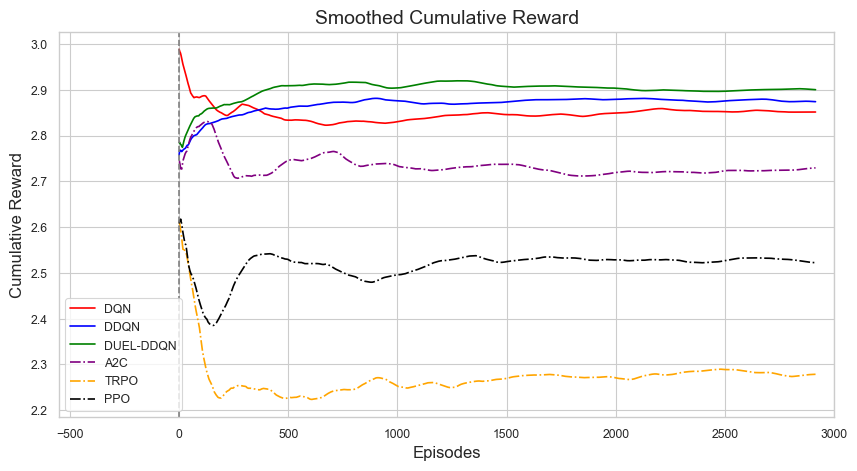

In [853]:
plt.figure(figsize=(10, 5))
W = 100
plt.plot(running_mean_last_n_samples(test_dqn_rew, W).cumsum()/(np.arange(len(running_mean_last_n_samples(test_dqn_rew, W).cumsum()))+1) , color="red", linestyle="-")
plt.plot(running_mean_last_n_samples(test_ddqn_rew, W).cumsum()/(np.arange(len(running_mean_last_n_samples(test_ddqn_rew, W).cumsum()))+1) , color="blue", linestyle="-")
plt.plot(running_mean_last_n_samples(test_dueldqn_rew, W).cumsum()/(np.arange(len(running_mean_last_n_samples(test_dueldqn_rew, W).cumsum()))+1) , color="green", linestyle="-")
plt.plot(running_mean_last_n_samples(test_a2c_rew, W).cumsum()/(np.arange(len(running_mean_last_n_samples(test_a2c_rew, W).cumsum()))+1) , color="purple", linestyle="-.")
plt.plot(running_mean_last_n_samples(test_trpo_rew, W).cumsum()/(np.arange(len(running_mean_last_n_samples(test_trpo_rew, W).cumsum()))+1) , color="orange", linestyle="-.")
plt.plot(running_mean_last_n_samples(test_ppo_rew, W).cumsum()/(np.arange(len(running_mean_last_n_samples(test_ppo_rew, W).cumsum()))+1) , color="black", linestyle="-.")
plt.xlim([-550, 3000])
plt.axvline(0, color="gray", linestyle="--")
plt.legend(["DQN", "DDQN", "DUEL-DDQN", "A2C", "TRPO", "PPO"], loc="lower left")
plt.ylabel("Cumulative Reward", fontsize=12)
plt.xlabel("Episodes", fontsize=12)
plt.savefig("../imgs/2_modeling/smoothed_cumulative_rewards_test.png", dpi=300, bbox_inches='tight')
plt.title("Smoothed Cumulative Reward", fontsize=14)


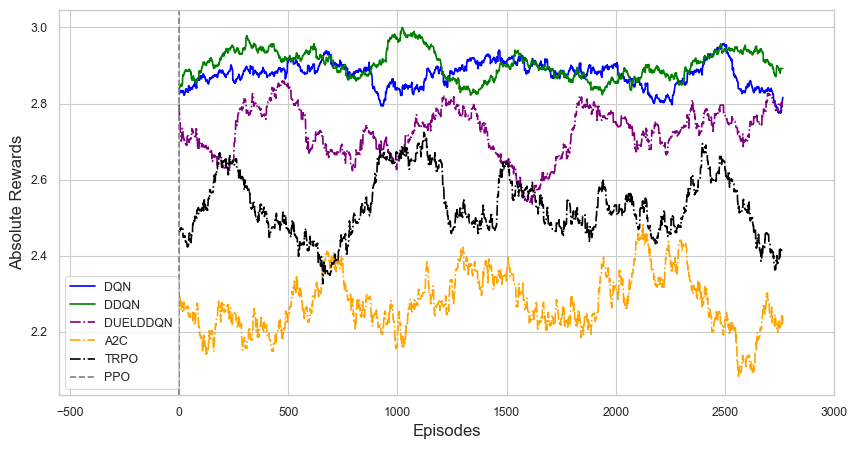

In [854]:
plt.figure(figsize=(10, 5))
plt.plot(running_mean_last_n_samples(test_ddqn_rew, 250) , color="blue", linestyle="-")
plt.plot(running_mean_last_n_samples(test_dueldqn_rew, 250) , color="green", linestyle="-")
plt.plot(running_mean_last_n_samples(test_a2c_rew, 250) , color="purple", linestyle="-.")
plt.plot(running_mean_last_n_samples(test_trpo_rew, 250) , color="orange", linestyle="-.")
plt.plot(running_mean_last_n_samples(test_ppo_rew, 250) , color="black", linestyle="-.")
plt.xlim([-550, 3000])
plt.axvline(0, color="gray", linestyle="--")
plt.ylabel("Absolute Rewards", fontsize=12)
plt.xlabel("Episodes", fontsize=12)
plt.legend(["DQN", "DDQN", "DUELDDQN", "A2C", "TRPO", "PPO"], loc="lower left")
plt.savefig("../imgs/2_modeling/smoothed_absolute_rewards_test.png", dpi=300, bbox_inches='tight')


In [803]:
test_gb_preds = model_gb.predict(test_subset[features])
print(classification_report(test_subset.default_120_12m.values,test_gb_preds))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1969
         1.0       1.00      1.00      1.00      1046

    accuracy                           1.00      3015
   macro avg       1.00      1.00      1.00      3015
weighted avg       1.00      1.00      1.00      3015



In [938]:
# print classification report for all test_rew
print("-"*30, "train_dqn_act", "-"*30)
print(classification_report(test_subset.default_120_12m.values, test_dqn_act))
print("-"*30, "train_ppo_act", "-"*30)
print(classification_report(test_subset.default_120_12m.values, test_ppo_act))
print("-"*30, "train_a2c_act", "-"*30)
print(classification_report(test_subset.default_120_12m.values, test_a2c_act))
print("-"*30, "train_trpo_act", "-"*30)
print(classification_report(test_subset.default_120_12m.values, test_trpo_act))
print("-"*30, "train_ddqn_act", "-"*30)
print(classification_report(test_subset.default_120_12m.values, test_ddqn_act))
print("-"*30, "train_dueldqn_act", "-"*30)
print(classification_report(test_subset.default_120_12m.values, test_duelddqn_act))
print("-"*30, "train_gb_preds", "-"*30)
test_gb_preds = model_gb.predict(test_subset[features])
print(classification_report(test_subset.default_120_12m.values,test_gb_preds))



------------------------------ train_dqn_act ------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      1969
         1.0       0.96      0.99      0.98      1046

    accuracy                           0.98      3015
   macro avg       0.98      0.99      0.98      3015
weighted avg       0.98      0.98      0.98      3015

------------------------------ train_ppo_act ------------------------------
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94      1969
         1.0       0.89      0.89      0.89      1046

    accuracy                           0.92      3015
   macro avg       0.91      0.92      0.91      3015
weighted avg       0.92      0.92      0.92      3015

------------------------------ train_a2c_act ------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97      1969
         

In [814]:
original_test_datecodes = list(test_date_map.keys())
test_datecodes = [dates_from_codes[code] for code in original_test_datecodes]

In [815]:
test_subset_original.shape, test_subset.shape, len(test_dqn_act)

((3015, 14), (3015, 12), 3015)

In [816]:
test_subset_original["date_code"].map(dict(zip(original_test_datecodes, test_datecodes)))

0       2021-07-31
1       2021-08-31
2       2021-09-30
3       2021-10-31
4       2021-11-30
           ...    
3010    2021-07-31
3011    2021-08-31
3012    2021-09-30
3013    2021-10-31
3014    2021-11-30
Name: date_code, Length: 3015, dtype: object

In [834]:
test_default_rate_hisotry = pd.DataFrame({"date": test_subset_original["date_code"].map(dict(zip(original_test_datecodes, test_datecodes))),
                          "actual": test_subset[default_col].values,
                          "dqn": test_dqn_act,
                          "ddqn": test_ddqn_act, 
                          "dueldqn": test_duelddqn_act,
                          "a2c": test_a2c_act, 
                          "trpo": test_trpo_act,
                        "ppo": test_ppo_act
                          # "mean" : np.quantile([test_dqn_act, test_ddqn_act, test_duelddqn_act, test_a2c_act, test_trpo_act], q=0.593, axis=0),
                          })

In [836]:
test_dr = test_default_rate_hisotry.groupby("date").mean()
test_dr

actual       dqn      ddqn   dueldqn       a2c      trpo  \
date                                                                     
2021-07-31  0.348259  0.359867  0.351575  0.348259  0.331675  0.320066   
2021-08-31  0.339967  0.353234  0.346600  0.346600  0.326700  0.308458   
2021-09-30  0.354892  0.358209  0.354892  0.356551  0.336650  0.325041   
2021-10-31  0.343284  0.353234  0.341625  0.344942  0.325041  0.316750   
2021-11-30  0.348259  0.359867  0.349917  0.348259  0.336650  0.318408   

                 ppo  
date                  
2021-07-31  0.353234  
2021-08-31  0.339967  
2021-09-30  0.358209  
2021-10-31  0.341625  
2021-11-30  0.349917

In [837]:
test_err_results = []

# Iterate over the columns in the DataFrame
for model in test_dfr.columns.drop('actual'):
    # Calculate RMSE
    rmse = mean_squared_error(test_dfr['actual'], test_dfr[model], squared=False)
    #mean absolute error
    mae = mean_absolute_error(test_dfr['actual'], test_dfr[model])

    rmse = mean_squared_error(test_dfr['actual'], test_dfr[model], squared=False)

    # Calculate R2 score
    r2 = r2_score(test_dfr['actual'], test_dfr[model])

    # Append the results to the list
    test_err_results.append({'model': model, 'r2': r2, 'mae': mae, 'rmse': rmse})

# Convert the list of results to a DataFrame
test_results_df = pd.DataFrame(test_err_results)
# results_df.sort_values(by="rmse", ascending=True)
test_results_df.sort_values(by="r2", ascending=False)

model         r2       mae      rmse
5      ppo   0.679487  0.002322  0.002872
2  dueldqn   0.615385  0.001990  0.003147
1     ddqn   0.529915  0.002653  0.003479
0      dqn  -3.316239  0.009950  0.010541
3      a2c  -8.722222  0.015589  0.015820
4     trpo -32.205128  0.029187  0.029236

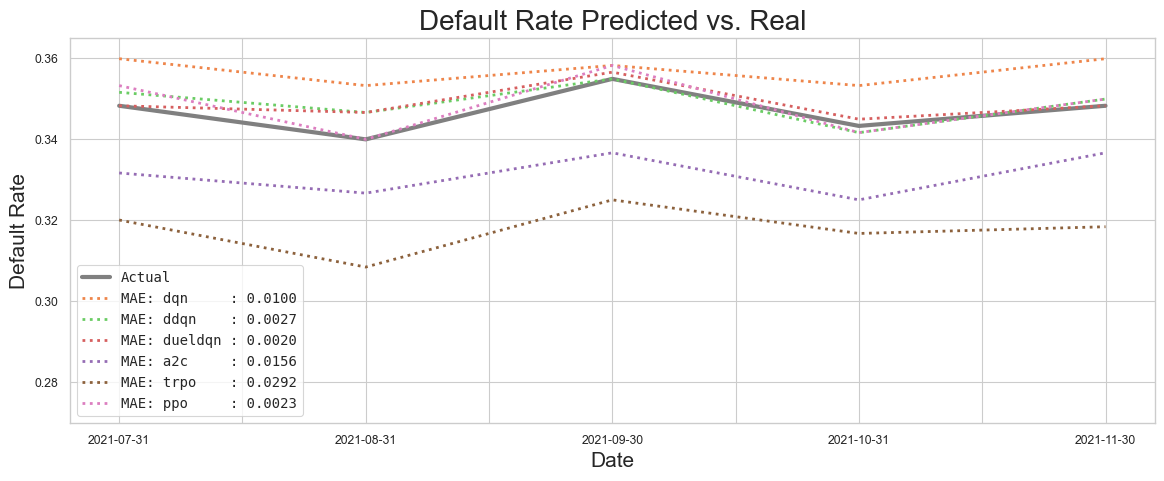

In [849]:

ax = test_dfr.plot(figsize=(14, 5))

# Set line styles and colors
ax.lines[0].set_linestyle("-")
ax.lines[0].set_color("gray")
ax.lines[0].set_linewidth(3)
[x.set_linestyle(':') for x in ax.lines[1:]]
[x.set_linewidth(2) for x in ax.lines[1:]]

# Find the longest string length for model names
longest_model_name = max(len(model) for model in test_results_df.model)

# Find the maximum length of the MAE strings to align the decimal points
max_mae_length = max(len(f"{mae:.4f}") for mae in test_results_df.mae)

# Create legend labels with padded model names and aligned MAE values
legend_labels = ['Actual'] + [
    f"MAE: {model}{' '*(longest_model_name - len(model))} : {mae:>{max_mae_length}.4f}"
    for model, mae in zip(test_results_df.model, test_results_df.mae)
]

# Set legend with formatted labels using a monospaced font
# set legend alpha

ax.legend(legend_labels, loc='lower left', prop={'family': 'monospace', 'size': 10})

plt.title("Default Rate Predicted vs. Real", fontsize=20)
plt.ylabel("Default Rate", fontsize=15)
plt.xlabel("Date", fontsize=15)
# Set minimum y axis
plt.ylim(0.27, 0.365)
# Save figure before calling show()
plt.savefig("../imgs/2_modeling/test_default_rate.png", dpi=300)

# Show the plot
plt.show()
plt.show()

# Other Evaluations

In [658]:
env_fns = [lambda : CustomEnv(train_subset, debug=True, scaled_features=SCALE, seed=SEED, rng = rng, accepts_discrete_action=True, **kwargs) for i in range(num_envs)]
training_env = SubprocVecEnv(env_fns)

dqn_mean_reward, dqn_std_reward  = evaluate_policy(model_dqn, training_env, n_eval_episodes=15*1,return_episode_rewards=True)

default: 0.333 - penalty: -1.83 reward:  2.65 - client:  207.0 month:   1 - done: True
default: 0.342 - penalty: -1.90 reward:  3.60 - client:  394.0 month:   2 - done: True
default: 0.342 - penalty: -1.83 reward:  3.61 - client:  470.0 month:   3 - done: True
default: 0.357 - penalty: -1.88 reward:  3.55 - client:  588.0 month:   4 - done: True
default: 0.318 - penalty: -1.68 reward:  2.74 - client:   26.0 month:   5 - done: True
default: 0.337 - penalty: -1.82 reward:  2.64 - client:  375.0 month:   6 - done: True
default: 0.332 - penalty: -1.84 reward:  2.65 - client:  191.0 month:   7 - done: True
default: 0.318 - penalty: -1.65 reward:  2.74 - client:  366.0 month:   8 - done: True
default: 0.318 - penalty: -1.66 reward:  2.74 - client:  248.0 month:   9 - done: True
default: 0.302 - penalty: -1.61 reward:  2.83 - client:  139.0 month:  10 - done: True
default: 0.317 - penalty: -1.73 reward:  2.74 - client:  528.0 month:  11 - done: True
default: 0.337 - penalty: -1.68 reward:  3.

In [659]:
env_fns = [lambda : CustomEnv(train_subset, debug=True, scaled_features=SCALE, seed=SEED, rng = rng, accepts_discrete_action=True, **kwargs) for i in range(num_envs)]
training_env = SubprocVecEnv(env_fns)

ddqn_mean_reward, ddqn_std_reward  = evaluate_policy(model_ddqn, training_env, n_eval_episodes=15*1,return_episode_rewards=True)

default: 0.333 - penalty: -1.83 reward:  2.65 - client:  207.0 month:   1 - done: True
default: 0.342 - penalty: -1.90 reward:  3.60 - client:  394.0 month:   2 - done: True
default: 0.342 - penalty: -1.83 reward:  3.61 - client:  470.0 month:   3 - done: True
default: 0.357 - penalty: -1.88 reward:  3.55 - client:  588.0 month:   4 - done: True
default: 0.318 - penalty: -1.68 reward:  2.74 - client:   26.0 month:   5 - done: True
default: 0.337 - penalty: -1.80 reward:  2.64 - client:  375.0 month:   6 - done: True
default: 0.332 - penalty: -1.84 reward:  2.65 - client:  191.0 month:   7 - done: True
default: 0.318 - penalty: -1.66 reward:  2.74 - client:  366.0 month:   8 - done: True
default: 0.318 - penalty: -1.66 reward:  2.74 - client:  248.0 month:   9 - done: True
default: 0.302 - penalty: -1.61 reward:  2.83 - client:  139.0 month:  10 - done: True
default: 0.317 - penalty: -1.74 reward:  2.74 - client:  528.0 month:  11 - done: True
default: 0.337 - penalty: -1.68 reward:  3.

In [660]:
env_fns = [lambda : CustomEnv(train_subset, debug=True, scaled_features=SCALE, seed=SEED, rng = rng, accepts_discrete_action=True, **kwargs) for i in range(num_envs)]
training_env = SubprocVecEnv(env_fns)

dueldqn_mean_reward, dueldqn_std_reward  = evaluate_policy(model_dueldqn, training_env, n_eval_episodes=15*1,return_episode_rewards=True)

default: 0.333 - penalty: -1.83 reward:  2.65 - client:  207.0 month:   1 - done: True
default: 0.342 - penalty: -1.90 reward:  3.60 - client:  394.0 month:   2 - done: True
default: 0.342 - penalty: -1.83 reward:  3.61 - client:  470.0 month:   3 - done: True
default: 0.357 - penalty: -1.88 reward:  3.55 - client:  588.0 month:   4 - done: True
default: 0.318 - penalty: -1.69 reward:  2.74 - client:   26.0 month:   5 - done: True
default: 0.337 - penalty: -1.81 reward:  2.64 - client:  375.0 month:   6 - done: True
default: 0.332 - penalty: -1.84 reward:  2.65 - client:  191.0 month:   7 - done: True
default: 0.318 - penalty: -1.66 reward:  2.74 - client:  366.0 month:   8 - done: True
default: 0.318 - penalty: -1.66 reward:  2.74 - client:  248.0 month:   9 - done: True
default: 0.302 - penalty: -1.61 reward:  2.83 - client:  139.0 month:  10 - done: True
default: 0.317 - penalty: -1.73 reward:  2.74 - client:  528.0 month:  11 - done: True
default: 0.337 - penalty: -1.68 reward:  3.

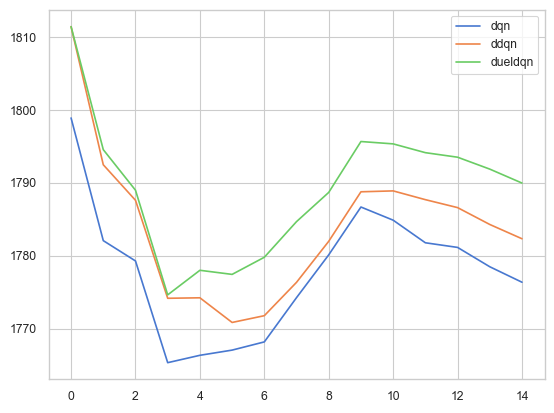

In [661]:
plt.plot(np.array(dqn_mean_reward).cumsum()/np.arange(1, len(dqn_mean_reward) + 1), label="dqn")
plt.plot(np.array(ddqn_mean_reward).cumsum()/np.arange(1, len(ddqn_mean_reward) + 1), label="ddqn")
plt.plot(np.array(dueldqn_mean_reward).cumsum()/np.arange(1, len(dueldqn_mean_reward) + 1), label="dueldqn")
plt.legend()
plt.show()

In [662]:
env_fns = [lambda : CustomEnv(train_subset, debug=True, scaled_features=SCALE, seed=SEED, rng = rng, accepts_discrete_action=True, **kwargs) for i in range(num_envs)]
training_env = SubprocVecEnv(env_fns)

a2c_mean_reward, a2c_std_reward  = evaluate_policy(model_a2c, training_env, n_eval_episodes=15*1,return_episode_rewards=True)

default: 0.333 - penalty: -1.80 reward:  2.65 - client:  207.0 month:   1 - done: True
default: 0.342 - penalty: -1.92 reward:  3.60 - client:  394.0 month:   2 - done: True
default: 0.342 - penalty: -1.84 reward:  3.61 - client:  470.0 month:   3 - done: True
default: 0.357 - penalty: -1.87 reward:  3.55 - client:  588.0 month:   4 - done: True
default: 0.318 - penalty: -1.71 reward:  2.73 - client:   26.0 month:   5 - done: True
default: 0.337 - penalty: -1.83 reward:  2.63 - client:  375.0 month:   6 - done: True
default: 0.332 - penalty: -1.85 reward:  2.65 - client:  191.0 month:   7 - done: True
default: 0.318 - penalty: -1.71 reward:  2.73 - client:  366.0 month:   8 - done: True
default: 0.318 - penalty: -1.66 reward:  2.74 - client:  248.0 month:   9 - done: True
default: 0.302 - penalty: -1.63 reward:  2.83 - client:  139.0 month:  10 - done: True
default: 0.317 - penalty: -1.76 reward:  2.73 - client:  528.0 month:  11 - done: True
default: 0.337 - penalty: -1.72 reward:  3.

In [663]:
env_fns = [lambda : CustomEnv(train_subset, debug=True, scaled_features=SCALE, seed=SEED, rng = rng, accepts_discrete_action=True, **kwargs) for i in range(num_envs)]
training_env = SubprocVecEnv(env_fns)

trpo_mean_reward, trpo_std_reward  = evaluate_policy(model_trpo, training_env, n_eval_episodes=15*1,return_episode_rewards=True)

default: 0.333 - penalty: -1.80 reward:  2.65 - client:  207.0 month:   1 - done: True
default: 0.342 - penalty: -1.93 reward:  3.60 - client:  394.0 month:   2 - done: True
default: 0.342 - penalty: -1.86 reward:  3.61 - client:  470.0 month:   3 - done: True
default: 0.357 - penalty: -1.86 reward:  3.55 - client:  588.0 month:   4 - done: True
default: 0.318 - penalty: -1.70 reward:  2.73 - client:   26.0 month:   5 - done: True
default: 0.337 - penalty: -1.84 reward:  2.63 - client:  375.0 month:   6 - done: True
default: 0.332 - penalty: -1.88 reward:  2.65 - client:  191.0 month:   7 - done: True
default: 0.318 - penalty: -1.74 reward:  2.73 - client:  366.0 month:   8 - done: True
default: 0.318 - penalty: -1.70 reward:  2.73 - client:  248.0 month:   9 - done: True
default: 0.302 - penalty: -1.57 reward:  2.84 - client:  139.0 month:  10 - done: True
default: 0.317 - penalty: -1.77 reward:  2.73 - client:  528.0 month:  11 - done: True
default: 0.337 - penalty: -1.73 reward:  3.

In [664]:
env_fns = [lambda : CustomEnv(train_subset, debug=True, scaled_features=SCALE, seed=SEED, rng = rng, accepts_discrete_action=True, **kwargs) for i in range(num_envs)]
training_env = SubprocVecEnv(env_fns)

ppo_mean_reward, ppo_std_reward  = evaluate_policy(model_ppo, training_env, n_eval_episodes=15*1,return_episode_rewards=True)

default: 0.333 - penalty: -1.87 reward:  2.64 - client:  207.0 month:   1 - done: True
default: 0.342 - penalty: -1.94 reward:  3.60 - client:  394.0 month:   2 - done: True
default: 0.342 - penalty: -1.86 reward:  3.61 - client:  470.0 month:   3 - done: True
default: 0.357 - penalty: -1.92 reward:  3.54 - client:  588.0 month:   4 - done: True
default: 0.318 - penalty: -1.68 reward:  2.74 - client:   26.0 month:   5 - done: True
default: 0.337 - penalty: -1.84 reward:  2.63 - client:  375.0 month:   6 - done: True
default: 0.332 - penalty: -1.85 reward:  2.65 - client:  191.0 month:   7 - done: True
default: 0.318 - penalty: -1.69 reward:  2.74 - client:  366.0 month:   8 - done: True
default: 0.318 - penalty: -1.69 reward:  2.74 - client:  248.0 month:   9 - done: True
default: 0.302 - penalty: -1.60 reward:  2.83 - client:  139.0 month:  10 - done: True
default: 0.317 - penalty: -1.69 reward:  2.74 - client:  528.0 month:  11 - done: True
default: 0.337 - penalty: -1.69 reward:  3.

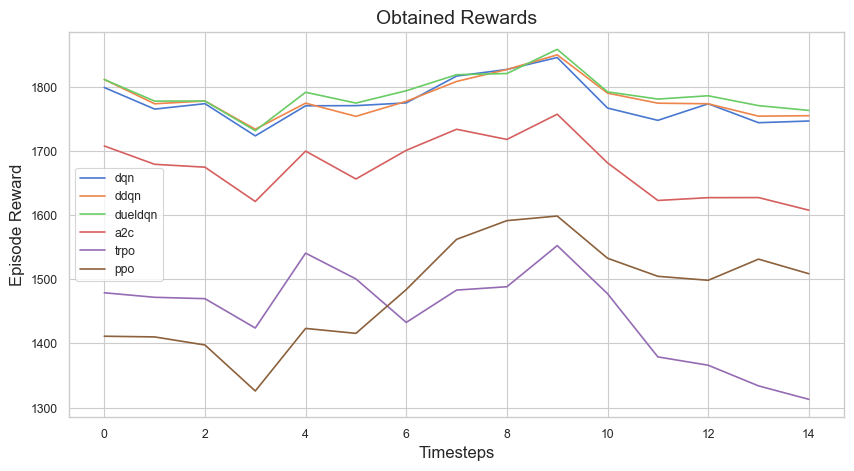

In [790]:
plt.figure(figsize=(10, 5))
plt.plot(np.array(dqn_mean_reward), label="dqn")
plt.plot(np.array(ddqn_mean_reward), label="ddqn")
plt.plot(np.array(dueldqn_mean_reward), label="dueldqn")
plt.plot(np.array(a2c_mean_reward), label="a2c")
plt.plot(np.array(trpo_mean_reward), label="trpo")
plt.plot(np.array(ppo_mean_reward), label="ppo")
plt.ylabel("Episode Reward", fontsize=12)
plt.xlabel("Timesteps", fontsize=12)
plt.title("Obtained Rewards", fontsize=14)
plt.legend()
plt.savefig("../imgs/2_modeling/obetained_rewards_all.png", dpi=300)
plt.show()



In [713]:
from sklearn.utils.class_weight import compute_class_weight

dummy = train_subset.copy().reset_index()
weight_schedule = []
for i in dummy["date_code"].unique():
    month_values = dummy[dummy["date_code"] == i][default_col].values
    weight_schedule.append(compute_class_weight(class_weight="balanced", classes=[0,1], y=month_values))

In [778]:
df_weight_schedule = pd.DataFrame(np.array(weight_schedule), columns=["w_0", "w_1"])
df_weight_schedule["date"] = [x for x in list(dates_from_codes.values())[:16]]
# df_weight_schedule["date"] = pd.to_datetime(df_weight_schedule["date"])
df_weight_schedule.set_index("date", inplace=True)

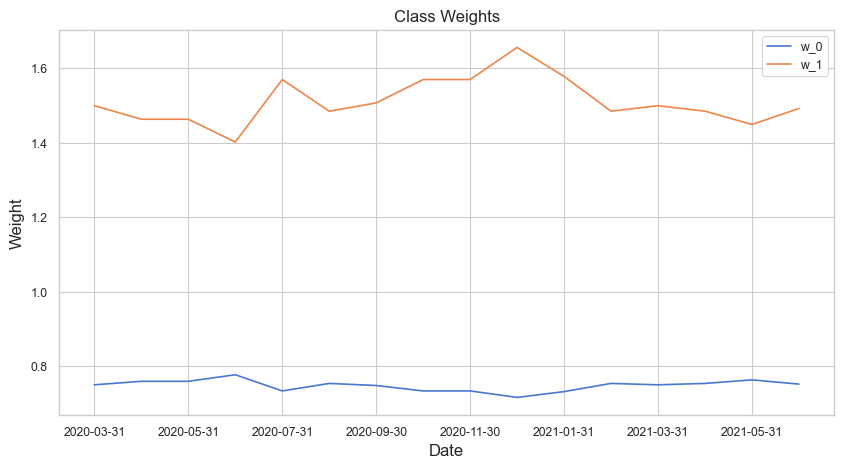

In [791]:
# import mdates from matplotlib
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(10, 5))
df_weight_schedule.plot(ax=ax)
ax.set_ylabel("Weight", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
ax.set_title("Class Weights", fontsize=12)
plt.savefig("../imgs/2_modeling/class_weights.png", dpi=300)

plt.show()

In [787]:
df_weight_schedule

w_0       w_1
date                          
2020-03-31  0.750000  1.500000
2020-04-30  0.759446  1.463592
2020-05-31  0.759446  1.463592
2020-06-30  0.777062  1.402326
2020-07-31  0.733577  1.570312
2020-08-31  0.753750  1.485222
2020-09-30  0.748139  1.507500
2020-10-31  0.733577  1.570312
2020-11-30  0.733577  1.570312
2020-12-31  0.716152  1.656593
2021-01-31  0.731796  1.578534
2021-02-28  0.753750  1.485222
2021-03-31  0.750000  1.500000
2021-04-30  0.753750  1.485222
2021-05-31  0.763291  1.449519
2021-06-30  0.751870  1.492574

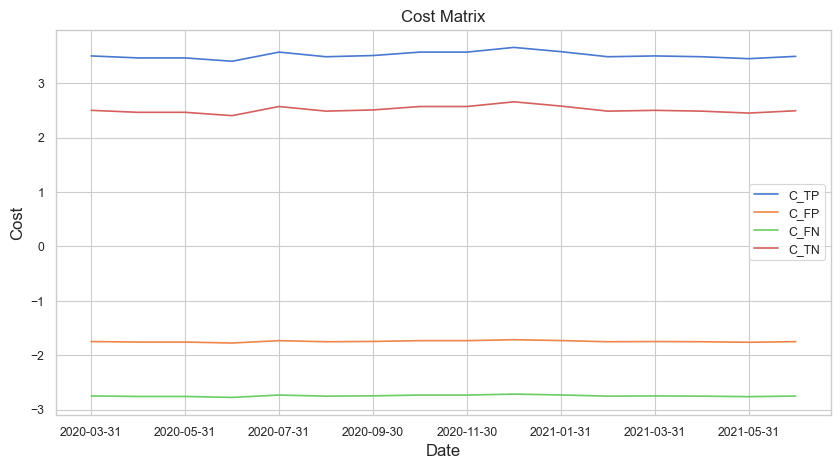

In [789]:
fig, ax = plt.subplots(figsize=(10, 5))
cost_matrix_schedule = pd.DataFrame({
    "C_TP": 2 + df_weight_schedule["w_1"],
    "C_FP": -1 - df_weight_schedule["w_0"],
    "C_FN": -2 - df_weight_schedule["w_0"],
    "C_TN": 1 + df_weight_schedule["w_1"],

})

cost_matrix_schedule.plot(ax=ax)
ax.set_ylabel("Cost", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
ax.set_title("Cost Matrix", fontsize=12)
plt.savefig("../imgs/2_modeling/cost_matrix_schedule.png", dpi=300)
plt.show()